<a href="https://colab.research.google.com/github/SergeiVKalinin/MSE_Spring2024/blob/main/Module%201/Homework_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework 4 for the MSE510 Course
- Instructor Sergei V. Kalinin, sergei2@utk.edu
- Please provide your name in the beginning of the notebook
- To submit the homework, please share it with my gmail address (available on Canvas)

In [1]:
!pip install pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 1.7 MB/s eta 0:00:00


In [2]:
import pysr

[juliapkg] Locating Julia ^1.6.1
[juliapkg] Querying Julia versions from https://julialang-s3.julialang.org/bin/versions.json
[juliapkg] WARNING: About to install Julia 1.10.1 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install.
[juliapkg]   If you use juliapkg in more than one environment, you are likely to have Julia
[juliapkg]   installed in multiple locations. It is recommended to install JuliaUp
[juliapkg]   (https://github.com/JuliaLang/juliaup) or Julia (https://julialang.org/downloads)
[juliapkg]   yourself.
[juliapkg] Downloading Julia from https://julialang-s3.julialang.org/bin/linux/x64/1.10/julia-1.10.1-linux-x86_64.tar.gz
             downloaded 67.3 MB of 160.1 MB
             download complete
[juliapkg] Verifying download
[juliapkg] Installing Julia 1.10.1 to /root/.julia/environments/pyjuliapkg/pyjuliapkg/install
[juliapkg] Using Julia 1.10.1 at /root/.julia/environments/pyjuliapkg/pyjuliapkg/install/bin/julia
[juliapkg] Using Julia project at /root/.julia/envir

# Loading Data

Run the code cell below

In [3]:
!gdown https://drive.google.com/uc?id=1UC6bu5nVFRBhHIL698jk0zt3AuDqREkV
!unzip hw3.zip

Downloading...
From: https://drive.google.com/uc?id=1UC6bu5nVFRBhHIL698jk0zt3AuDqREkV
To: /content/hw3.zip
100% 9.96k/9.96k [00:00<00:00, 13.0MB/s]
Archive:  hw3.zip
  inflating: hw3p1.csv               
  inflating: hw3p2.csv               
  inflating: hw3p3.csv               


If the !gdown does not work, I have placed the copy of the file on the GitHub, so you can get it from https://github.com/SergeiVKalinin/MSE_Spring2024/blob/main/Module%201/hw3.zip

Now you have created 3 csv files, named hw3p1, hw3p2, and hw3p3 respectively. Load the file hw3p1 into Pandas DataFrame. It will contain three sets of data representing x and corresponding f(x). There are three sets of data overall.

# 1D Fit by PySR

Problem 1. Fit the first set of data using the PySR

Problem 2. Fit the second set of data using the PySR

Problem 3. Fit the third set of data using PySR

# 2D Fit by PySR

Load the file hw3p2 into Pandas DataFrame. It will contain values of x, y, and f = f(x,y)

Problem 4: Fit f(x,y) using the PySR

# Discovering physics of Ising model

- The Ising model is by Rama Vasudevan, vasudevanrk@ornl.gov
- Some of the wrapper code by Arpan Biswas, https://scholar.google.com/citations?hl=en&user=CGqi9FAAAAAJ  
- Ising Model Wiki, https://en.wikipedia.org/wiki/Ising_model  

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.random import rand

from tqdm import tqdm
from typing import Union, Dict, Callable

import math
import time

In [5]:
# @title Ising model code
class IsingSim():

  """This class performs Ising model simulations on a 2D grid. Interaction parameters are given by a matrix at each lattice site.
  Field dependence is not supported at this time but will be in due course. The simulator outputs configurations after equlibrium
  as well as the trajectories, if specifically requested.
  Inputs:
    - N : (integer) - Size of lattice will be N^2. Only 2D square lattice is supported at this stage.
    - J_mat: (numpy matrix of shape(5,5)) - entries being floats for interaction parameters. Self-interaction (middle element of matrix)=0.
    - T: (float) - Reduced temperature for simulation
    - save_trajectories: (Boolean) - whether to save trajectories, or only final state. Default False.
    - eqSteps: (integer) number of Monte-Carlo steps for equlibration before simulation starts. Default 750. AKA 'burn-in'.
    - mcSteps: (integer) number of Monte-Carlo for simulation. Default 750.
  Outputs: Several outputs are available, including trajectories (if called), configurations (i.e., the 2D states) and configurations histograms.
  These can be obtained by calling methods self.configurations(), self.histograms() and self.trajectories()"""

  def __init__(self, N = 40, J_mat = None, T = 2.7, save_trajectories = False,
               eqSteps = 750, mcSteps = 750):
    self.N = N

    #If no J matrix is provided we default to isotropic J interaction with NN with value 0.5
    if np.array(J_mat).all() == None:
      J_mat = np.zeros((5,5))
      J_mat[1,2] = J_mat[2,1] = J_mat[2,3] = J_mat[3,2] = 0.5 #Defaulting to 0.5 for NN, all others zeroed out.

    self.J_mat = J_mat

    self.save_trajectories = save_trajectories
    self.eqSteps = eqSteps
    self.mcSteps = mcSteps
    self.config = self.initialState(random = False)
    self.T = T

  def initialState(self, random = False):
    ''' Generates a lattice with spin configurations drawn randomly [-1 or 1] if random=True
    Else, the lattice is generated with all sites = 1 '''

    if random==True: state = 2*np.random.randint(2, size=(self.N,self.N))-1
    else: state = np.ones([self.N,self.N])

    return state

  def mcmove(self, config):
    '''Monte Carlo move using Metropolis algorithm '''

    M = 5 #neighborhood size (M^2). Do not change!
    beta = 1.0/self.T

    for i in range(self.N):
      for j in range(self.N):
        J_mat = self.J_mat
        cost = 0.0
        s =  np.copy(config[i, j])

        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            cost += 2 * J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

        if cost < 0:
          s *= -1
        elif rand() < np.exp(-cost*beta):
          s *= -1
        config[i, j] = s
    return config


  def calcEnergy(self, config):
    '''Returns the energy of the current configuration'''
    M = 5
    energy = 0.0
    for i in range(len(config)):
      for j in range(len(config)):
        J_mat = self.J_mat #otherwise, no

        s = config[i,j]
        for p in range(-int(M/2), int(M/2)+1, 1):
          for q in range(-int(M/2), int(M/2)+1, 1):
            energy += -J_mat[int(M/2)+p, int(M/2)+q] * config[(i+p)%self.N,(j+q)%self.N] * config[i,j]

    return energy/4.0


  def calcMag(self, config):
    '''Magnetization of a given configuration'''
    return np.sum(config)

  def calcAbsMag(self, config):
    ''' Absolute Magnetization of a given configuration'''
    return (np.abs(np.sum(config)))*1.0

  def performIsingSim(self):

    E1, M1, E2, M2 = 0.0,0.0,0.0,0.0    #These are all the average properties of all MC steps used
    E_traj, M_traj = np.zeros(self.mcSteps), np.zeros(self.mcSteps)

    config = np.copy(self.config)
    T = self.T
    if self.save_trajectories: config_mat = np.zeros([self.mcSteps,self.N,self.N])   #Saving all the configurations


    print('\n---Performing Equlibration---\n')
    for i in tqdm(range(self.eqSteps)):
        config = self.mcmove(config)

    print('\n---Finished...\n----Performing MC Moves----\n')
    for j in tqdm(range(self.mcSteps)):
        config = self.mcmove(config)
        Ene, Mag = self.calcEnergy(config), self.calcAbsMag(config)
        E_traj[j] = self.calcEnergy(config)/(self.N*self.N)
        M_traj[j] = self.calcAbsMag(config)/(self.N*self.N)

        E1 = E1 + Ene
        M1 = M1 + Mag
        M2 = M2 + Mag * Mag
        E2 = E2 + Ene * Ene

        if self.save_trajectories: config_mat[j] = config

    print('Completed. Saving')
    Energy = E1 / (self.mcSteps * self.N * self.N)
    Magnetization = M1 / (self.mcSteps * self.N * self.N)
    n1, n2  = 1.0/(self.mcSteps*self.N*self.N), 1.0/(self.mcSteps*self.mcSteps*self.N*self.N)
    iT = 1.0/self.T
    iT2 = iT*iT
    SpecificHeat = (n1*E2 - n2*E1*E1)*iT2
    Susceptibility = (n1*M2 - n2*M1*M1)*iT
    # SpecificHeat = (E2 / self.mcSteps - E1 * E1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T * self.T)
    # Susceptibility = (M2 / self.mcSteps - M1 * M1 / (self.mcSteps * self.mcSteps)) / (self.N * self.T)

    self.config = config


    if self.save_trajectories:
      results_dict = {'config': config_mat, 'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility, 'E_traj': E_traj,
      'M_traj': M_traj,
      }
    else:
      results_dict = {'Energy': Energy, 'Magnetization': Magnetization,
      'SpecificHeat': SpecificHeat, 'Susceptibility': Susceptibility,
      'E_traj': E_traj, 'M_traj': M_traj,}

    self.results = results_dict

    return 'Completed simulation'

## Ground states

Use the code below to experiment with the Ising model. The 5x5 matrix defines interstions strength between central spin and neighbours.  


---Performing Equlibration---



100%|██████████| 50/50 [00:01<00:00, 45.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:04<00:00, 11.78it/s]


Completed. Saving


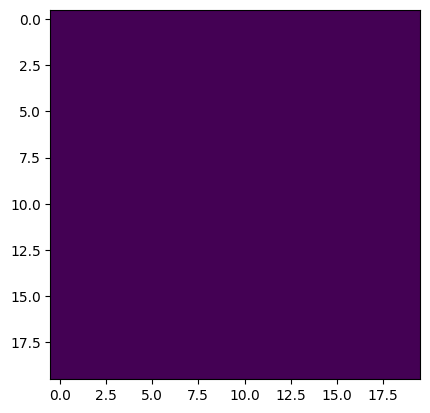

In [6]:
results_dict = {}
approx_ys = np.zeros(1)
time_eval = np.zeros(1)

J_mat = np.array([[0,0,0,0,0],
                  [0,0,1,0,0],
                  [0,1,0,1,0],
                  [0,0,1,0,0],
                  [0,0,0,0,0]])

start_time = time.time()

np.random.seed(0)
sq_sim = IsingSim(N = 20, J_mat = J_mat, T = 0.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
sq_sim.performIsingSim()   # Running the sim
end_time = time.time()
time_eval = end_time-start_time

results_dict[0] = {'sim': sq_sim.results,}
approx_ys[0] = results_dict[0]['sim']['SpecificHeat']
plt.imshow(results_dict[0]['sim']['config'][-1])
plt.show()

Problem 5: What ground states do we get if:
- The NN interactions are 1
- The NN interctions are -1
- 2 of the NN are 1 and 2 are -1?
- Experiment with the NNN interactions, e.g. use the matrix as
                ([[0,0,0,0,0],
                  [0,A,B,A,0],
                  [0,B,0,B,0],
                  [0,A,B,A,0],
                  [0,0,0,0,0]])
and experiment what happens for different combinations on signs of A and B.

Answer 5:

## Evaluation

The code below allows to run the Ising model code for a range of parameters.
- Choose your own values of parameters (for the time being, code is set to change only NN interactions, but please choose other elements of J's matrix to be non-zero)
- If you feel adventurous, experiment with the 2D parameter spaces (i.e. explore behavior as a fucntion of 2 of the exchange integrals)

In [7]:
lb = 0
ub = 3
N_total = 201

#bounds = np.array((lb, ub), dtype=float)
xs = np.linspace(lb, ub, N_total)

Full grid evaluation for 20x20 1D Ising model - Square Model

Recommended parameters:
- 20x20 field
- 300 steps for equilibration
- 300 steps for computation

However, if you are impatient, run (10x10, 50, 50) for quick checks.

Evaluation 1 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 50.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:02<00:00, 24.88it/s]


Completed. Saving
Time (s) to complete simulation 1: 3.037626028060913


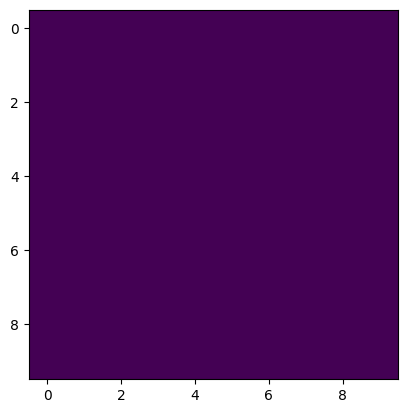

Evaluation 2 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 82.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 29.05it/s]


Completed. Saving
Time (s) to complete simulation 2: 2.375352621078491


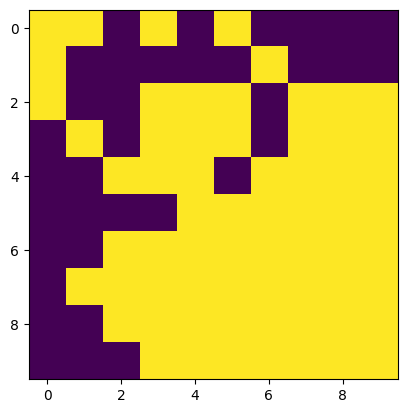

Evaluation 3 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 65.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 25.82it/s]


Completed. Saving
Time (s) to complete simulation 3: 2.7376089096069336


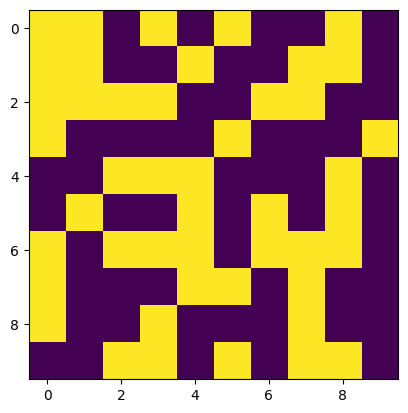

Evaluation 4 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 105.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 41.65it/s]


Completed. Saving
Time (s) to complete simulation 4: 1.7260770797729492


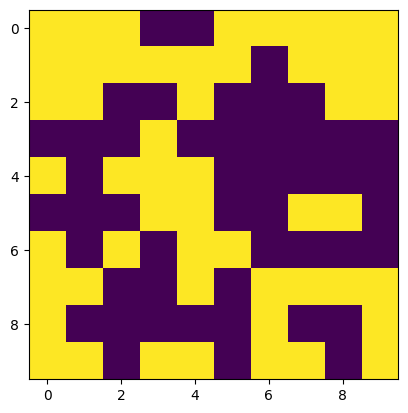

Evaluation 5 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 53.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:02<00:00, 19.87it/s]


Completed. Saving
Time (s) to complete simulation 5: 3.4821090698242188


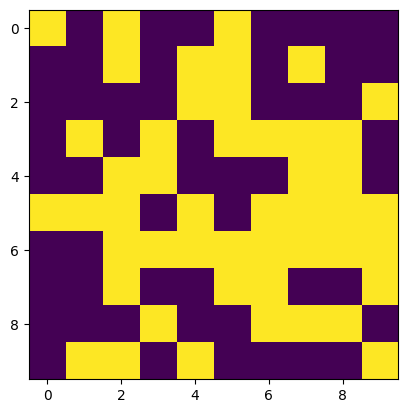

Evaluation 6 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 214.23it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.39it/s]


Completed. Saving
Time (s) to complete simulation 6: 0.8063979148864746


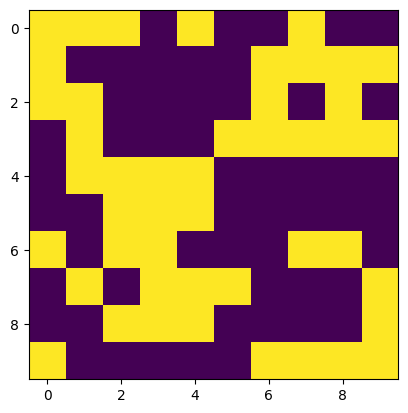

Evaluation 7 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.48it/s]


Completed. Saving
Time (s) to complete simulation 7: 0.830216646194458


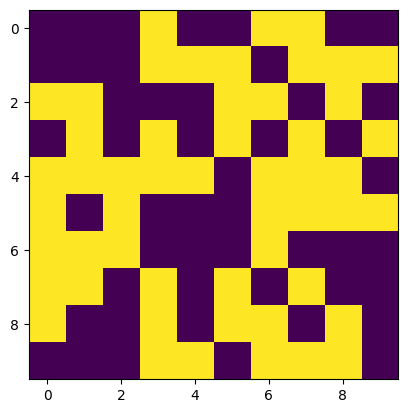

Evaluation 8 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.59it/s]


Completed. Saving
Time (s) to complete simulation 8: 0.8288578987121582


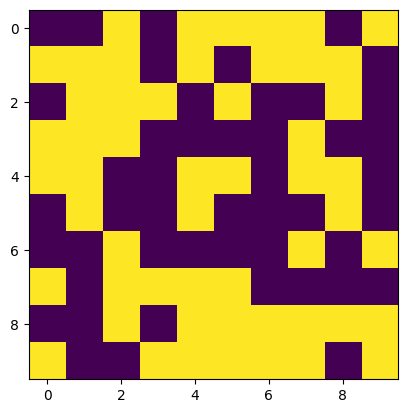

Evaluation 9 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.75it/s]


Completed. Saving
Time (s) to complete simulation 9: 0.830864667892456


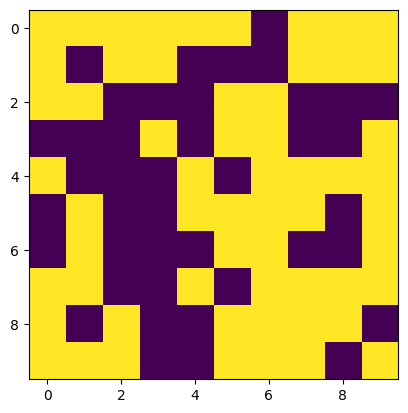

Evaluation 10 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 92.48it/s]


Completed. Saving
Time (s) to complete simulation 10: 0.7830653190612793


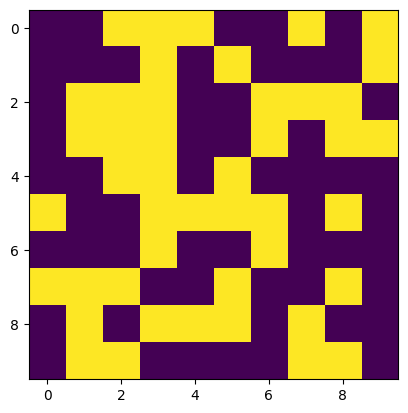

Evaluation 11 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 240.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 93.11it/s]


Completed. Saving
Time (s) to complete simulation 11: 0.7670600414276123


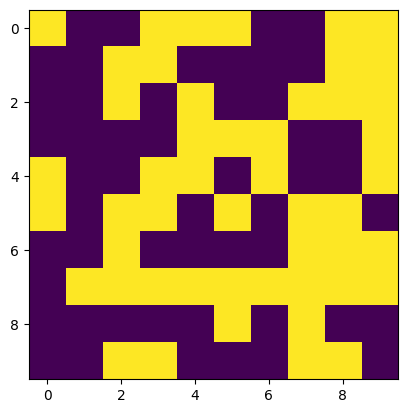

Evaluation 12 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 244.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.82it/s]


Completed. Saving
Time (s) to complete simulation 12: 0.7764029502868652


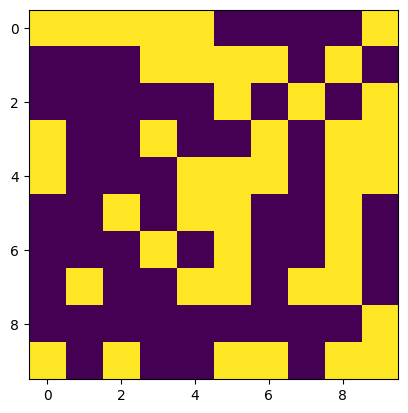

Evaluation 13 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 234.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.89it/s]


Completed. Saving
Time (s) to complete simulation 13: 0.7859978675842285


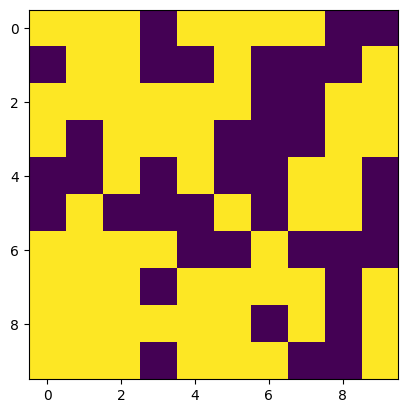

Evaluation 14 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 251.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.45it/s]


Completed. Saving
Time (s) to complete simulation 14: 0.7699205875396729


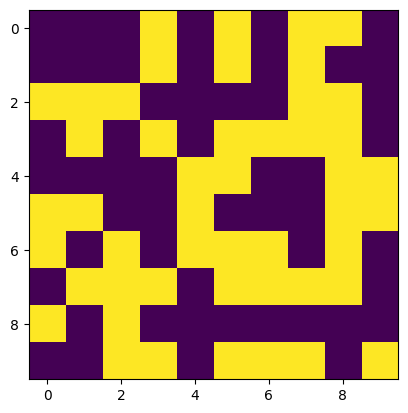

Evaluation 15 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 251.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.52it/s]


Completed. Saving
Time (s) to complete simulation 15: 1.0933022499084473


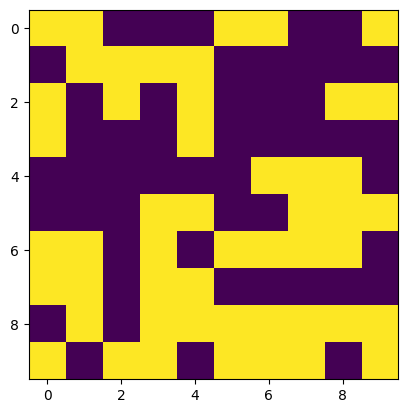

Evaluation 16 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 125.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.00it/s]


Completed. Saving
Time (s) to complete simulation 16: 1.3836827278137207


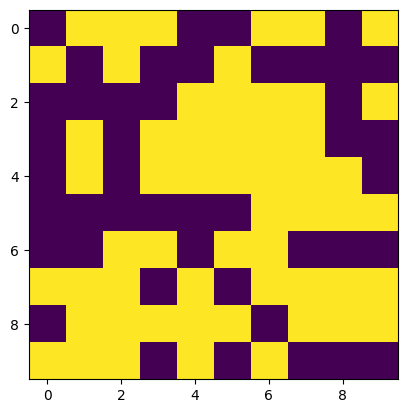

Evaluation 17 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.15it/s]


Completed. Saving
Time (s) to complete simulation 17: 0.8006677627563477


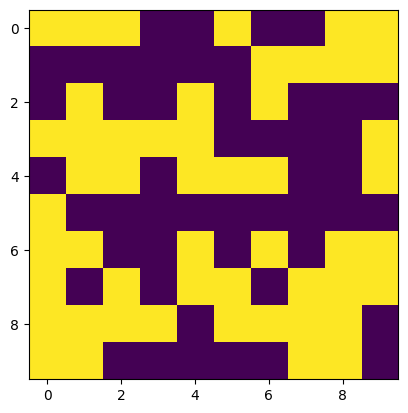

Evaluation 18 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 250.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.92it/s]


Completed. Saving
Time (s) to complete simulation 18: 0.7722318172454834


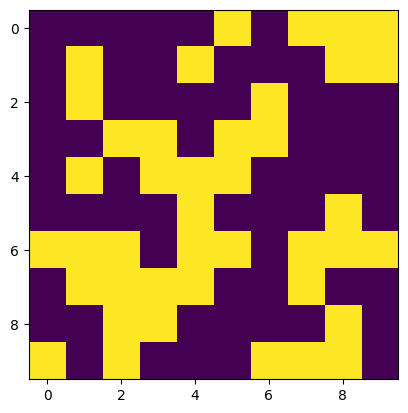

Evaluation 19 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 236.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.15it/s]


Completed. Saving
Time (s) to complete simulation 19: 0.8095710277557373


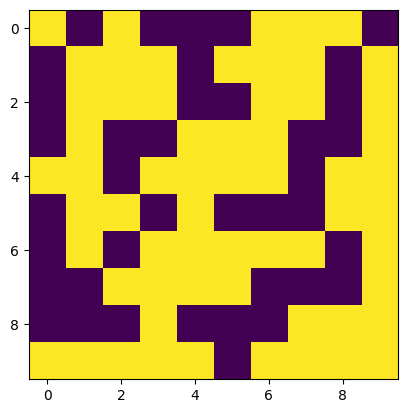

Evaluation 20 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 228.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.30it/s]


Completed. Saving
Time (s) to complete simulation 20: 0.8106131553649902


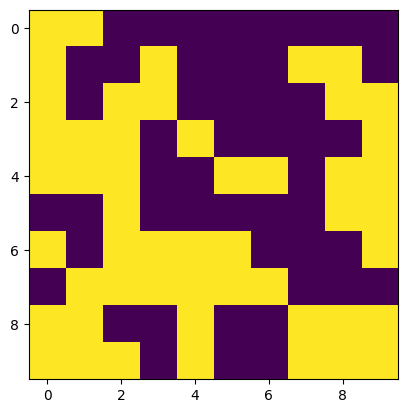

Evaluation 21 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 231.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.25it/s]


Completed. Saving
Time (s) to complete simulation 21: 0.8069980144500732


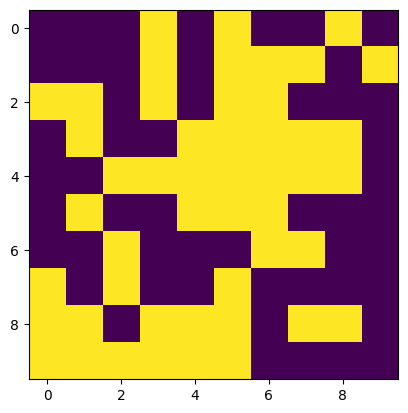

Evaluation 22 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.75it/s]


Completed. Saving
Time (s) to complete simulation 22: 0.8145761489868164


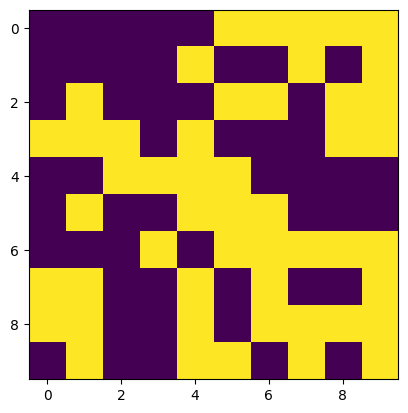

Evaluation 23 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 219.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.23it/s]


Completed. Saving
Time (s) to complete simulation 23: 0.8171384334564209


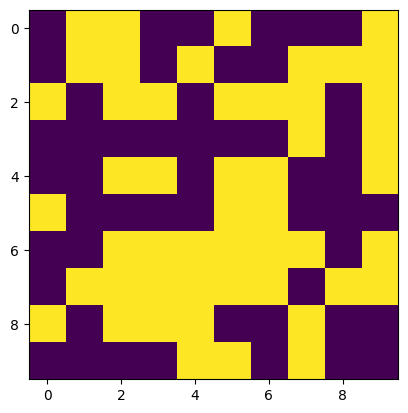

Evaluation 24 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.40it/s]


Completed. Saving
Time (s) to complete simulation 24: 0.8175137042999268


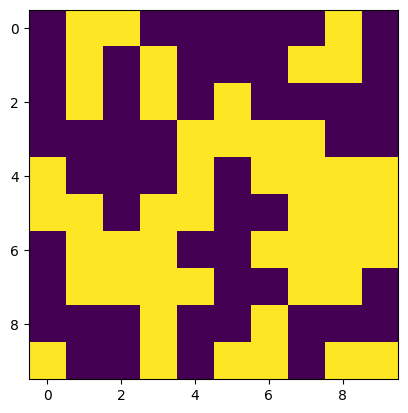

Evaluation 25 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 241.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.48it/s]


Completed. Saving
Time (s) to complete simulation 25: 0.7830758094787598


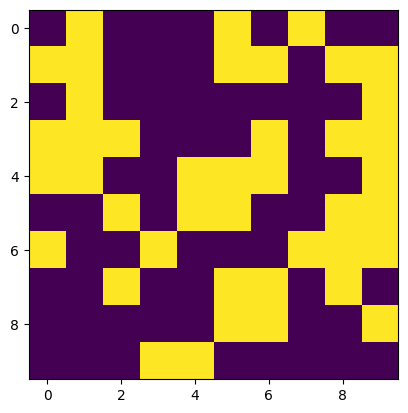

Evaluation 26 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.09it/s]


Completed. Saving
Time (s) to complete simulation 26: 0.8135802745819092


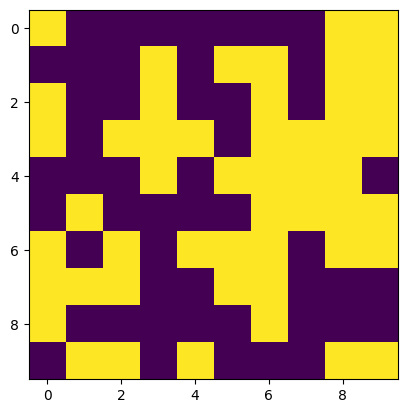

Evaluation 27 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.01it/s]


Completed. Saving
Time (s) to complete simulation 27: 1.3746275901794434


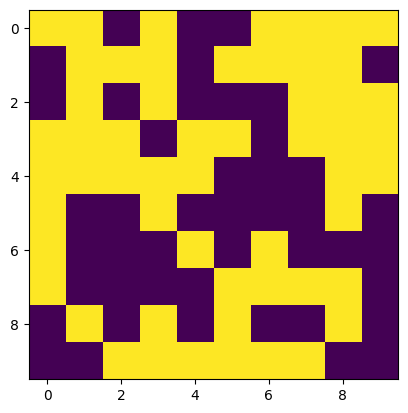

Evaluation 28 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 62.85it/s]


Completed. Saving
Time (s) to complete simulation 28: 1.2021677494049072


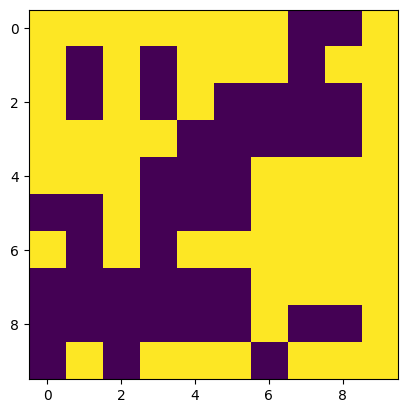

Evaluation 29 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 225.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.76it/s]


Completed. Saving
Time (s) to complete simulation 29: 0.8084492683410645


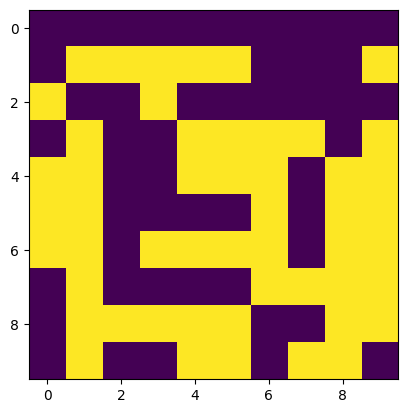

Evaluation 30 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 234.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.02it/s]


Completed. Saving
Time (s) to complete simulation 30: 0.7868001461029053


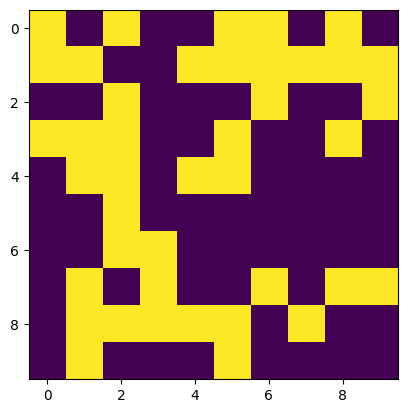

Evaluation 31 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.81it/s]


Completed. Saving
Time (s) to complete simulation 31: 0.8015310764312744


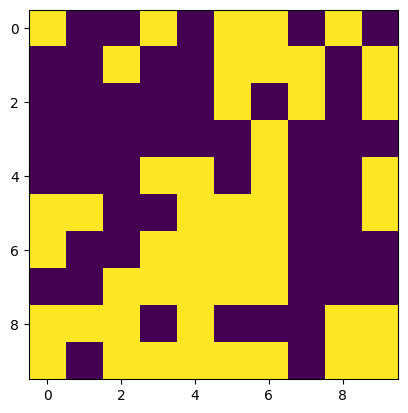

Evaluation 32 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 224.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.23it/s]


Completed. Saving
Time (s) to complete simulation 32: 0.8265030384063721


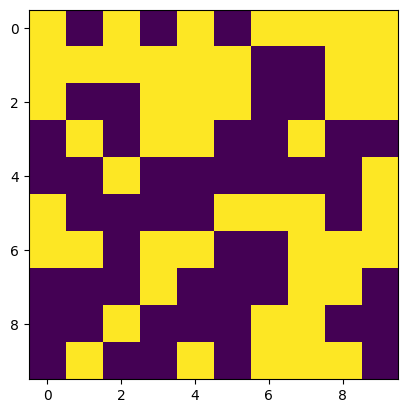

Evaluation 33 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 241.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.62it/s]


Completed. Saving
Time (s) to complete simulation 33: 0.7907757759094238


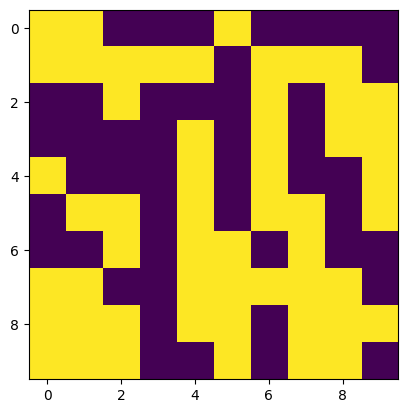

Evaluation 34 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.98it/s]


Completed. Saving
Time (s) to complete simulation 34: 0.8051421642303467


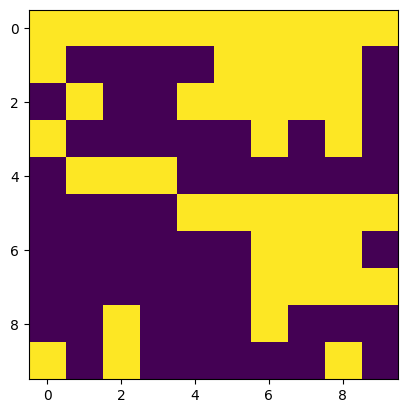

Evaluation 35 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 90.92it/s]


Completed. Saving
Time (s) to complete simulation 35: 0.7851309776306152


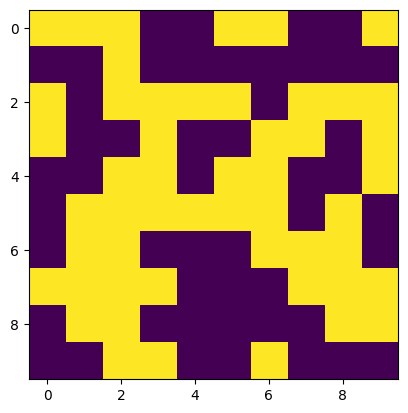

Evaluation 36 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 230.12it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.08it/s]


Completed. Saving
Time (s) to complete simulation 36: 0.793553352355957


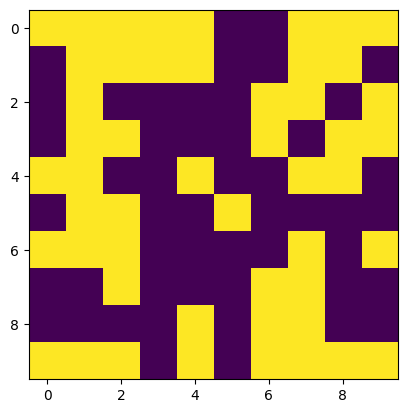

Evaluation 37 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.50it/s]


Completed. Saving
Time (s) to complete simulation 37: 0.8021204471588135


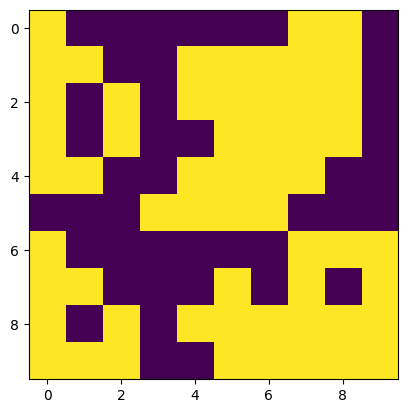

Evaluation 38 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 229.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 58.83it/s]


Completed. Saving
Time (s) to complete simulation 38: 1.083892583847046


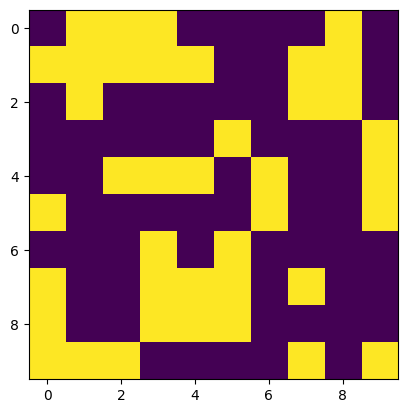

Evaluation 39 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.69it/s]


Completed. Saving
Time (s) to complete simulation 39: 1.4410316944122314


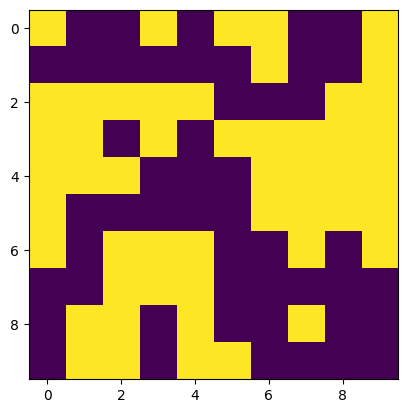

Evaluation 40 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 107.58it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.88it/s]


Completed. Saving
Time (s) to complete simulation 40: 1.5280978679656982


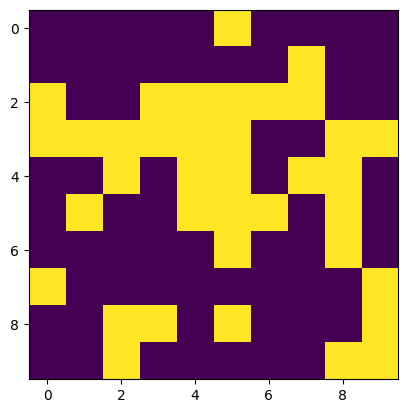

Evaluation 41 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 57.34it/s]


Completed. Saving
Time (s) to complete simulation 41: 1.2692806720733643


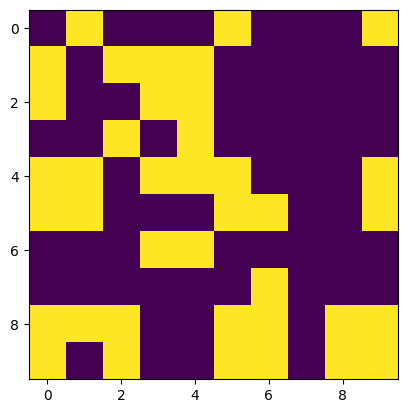

Evaluation 42 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 240.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.17it/s]


Completed. Saving
Time (s) to complete simulation 42: 0.8187313079833984


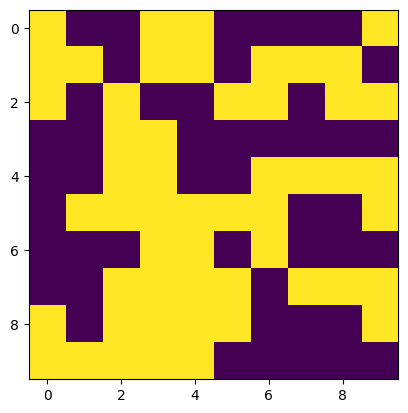

Evaluation 43 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 226.46it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.99it/s]


Completed. Saving
Time (s) to complete simulation 43: 0.845395565032959


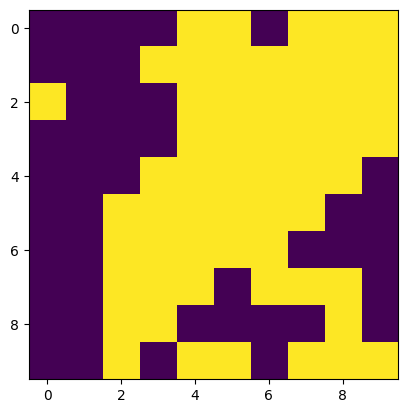

Evaluation 44 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 213.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 89.32it/s]


Completed. Saving
Time (s) to complete simulation 44: 0.8099148273468018


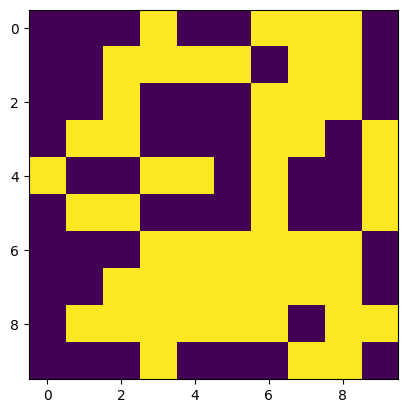

Evaluation 45 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.77it/s]


Completed. Saving
Time (s) to complete simulation 45: 0.8311140537261963


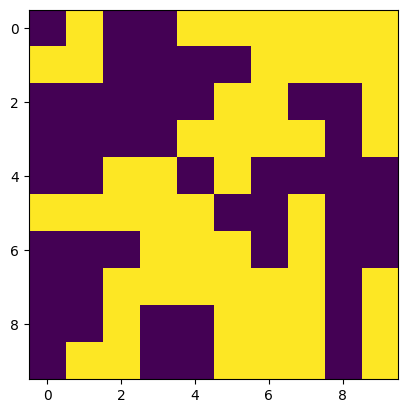

Evaluation 46 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 88.27it/s]


Completed. Saving
Time (s) to complete simulation 46: 0.818260669708252


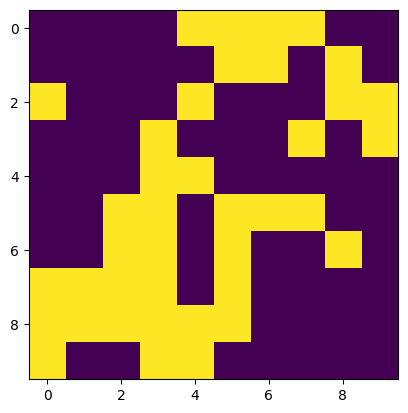

Evaluation 47 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.24it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.54it/s]


Completed. Saving
Time (s) to complete simulation 47: 0.8391447067260742


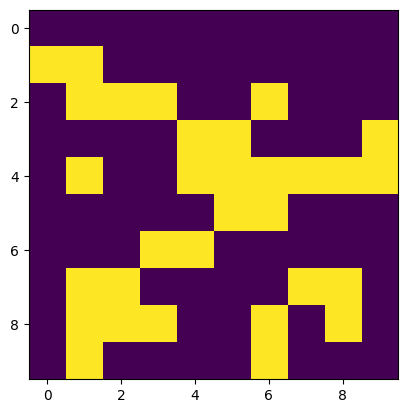

Evaluation 48 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 218.93it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.36it/s]


Completed. Saving
Time (s) to complete simulation 48: 0.8198416233062744


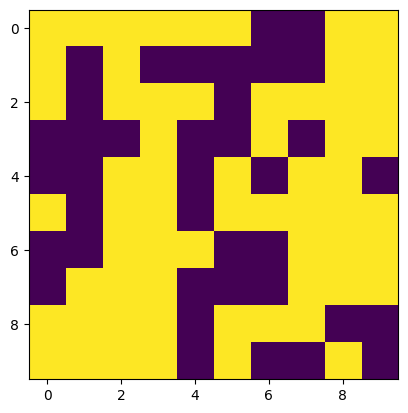

Evaluation 49 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 127.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.16it/s]


Completed. Saving
Time (s) to complete simulation 49: 1.4296581745147705


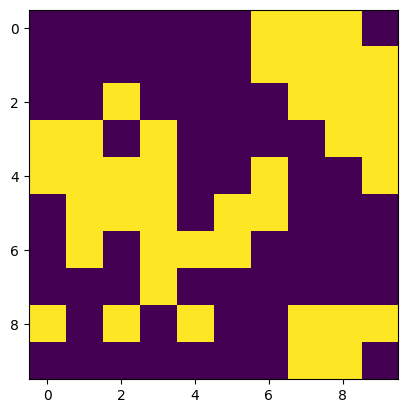

Evaluation 50 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 59.87it/s]


Completed. Saving
Time (s) to complete simulation 50: 1.2503859996795654


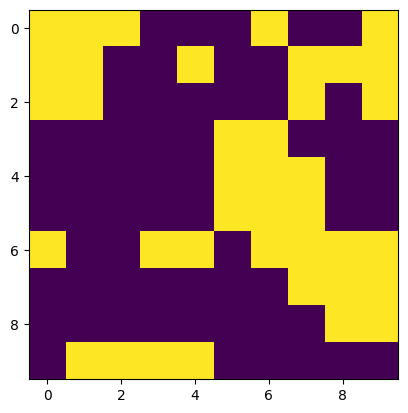

Evaluation 51 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.39it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.60it/s]


Completed. Saving
Time (s) to complete simulation 51: 0.8605542182922363


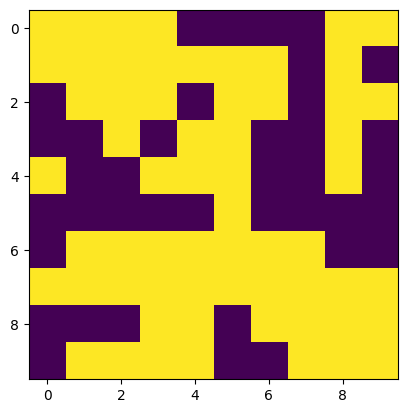

Evaluation 52 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.50it/s]


Completed. Saving
Time (s) to complete simulation 52: 0.8157696723937988


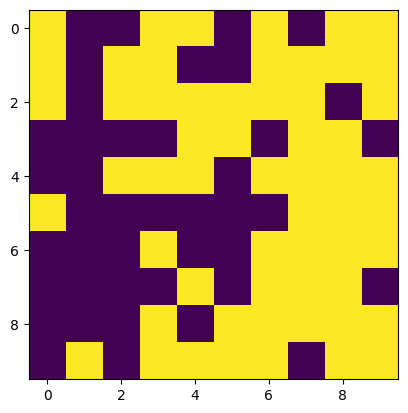

Evaluation 53 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.94it/s]


Completed. Saving
Time (s) to complete simulation 53: 0.8426568508148193


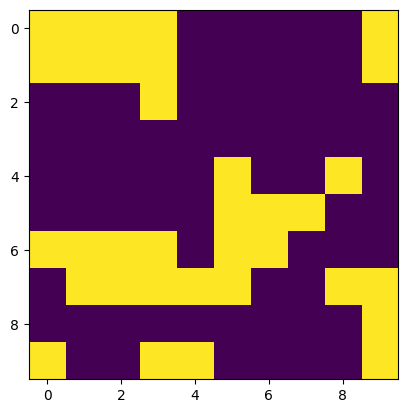

Evaluation 54 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 221.11it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.41it/s]


Completed. Saving
Time (s) to complete simulation 54: 0.84295654296875


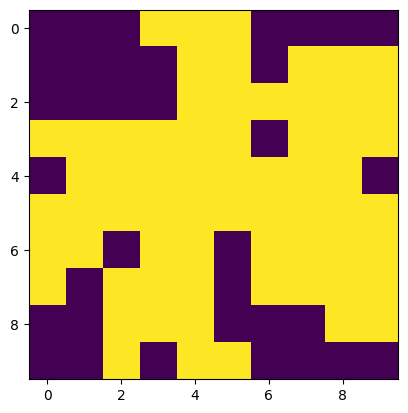

Evaluation 55 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.90it/s]


Completed. Saving
Time (s) to complete simulation 55: 0.8471128940582275


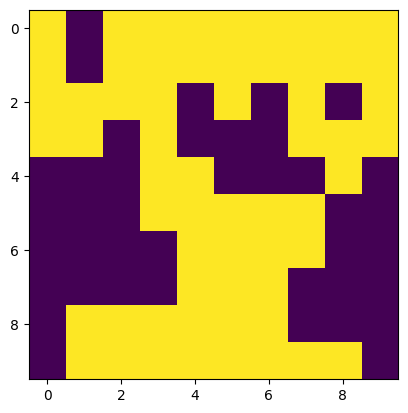

Evaluation 56 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.53it/s]


Completed. Saving
Time (s) to complete simulation 56: 0.846271276473999


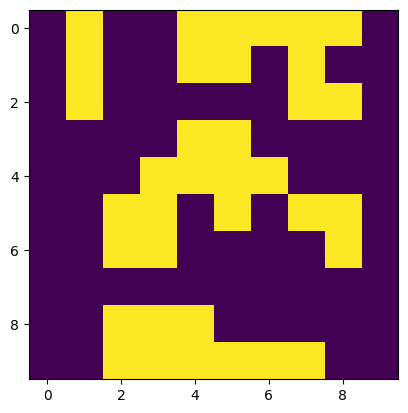

Evaluation 57 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.30it/s]


Completed. Saving
Time (s) to complete simulation 57: 0.838850736618042


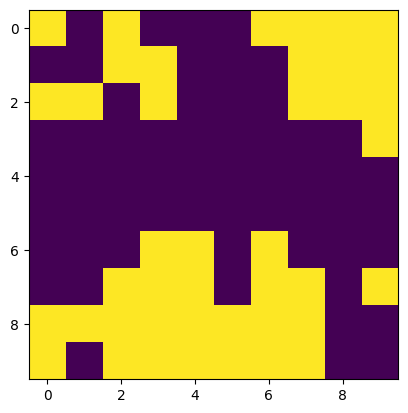

Evaluation 58 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.20it/s]


Completed. Saving
Time (s) to complete simulation 58: 0.8474702835083008


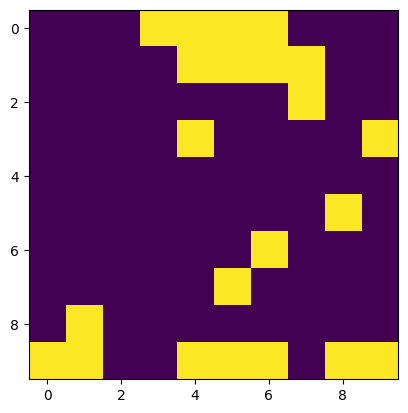

Evaluation 59 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.70it/s]


Completed. Saving
Time (s) to complete simulation 59: 0.8348112106323242


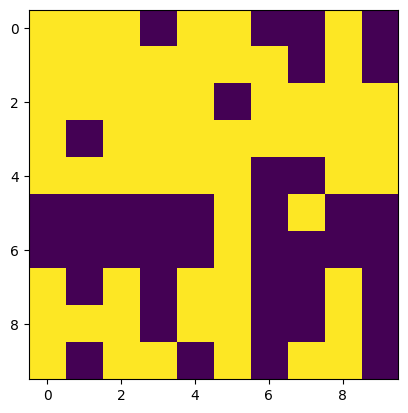

Evaluation 60 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 165.30it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.70it/s]


Completed. Saving
Time (s) to complete simulation 60: 1.3796114921569824


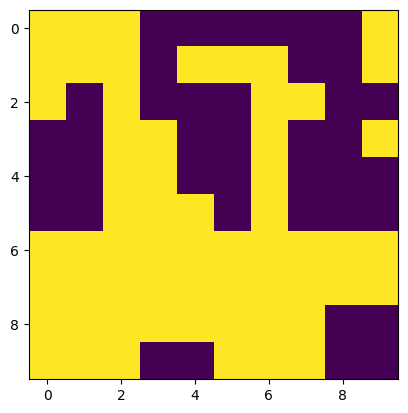

Evaluation 61 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.53it/s]


Completed. Saving
Time (s) to complete simulation 61: 1.4008629322052002


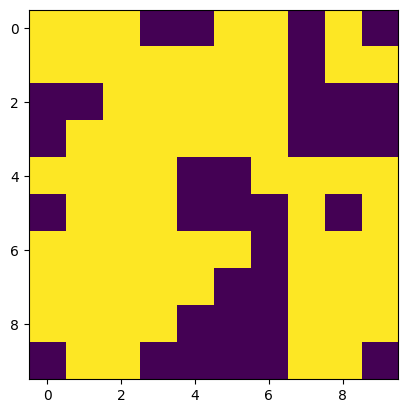

Evaluation 62 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 216.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.46it/s]


Completed. Saving
Time (s) to complete simulation 62: 0.832042932510376


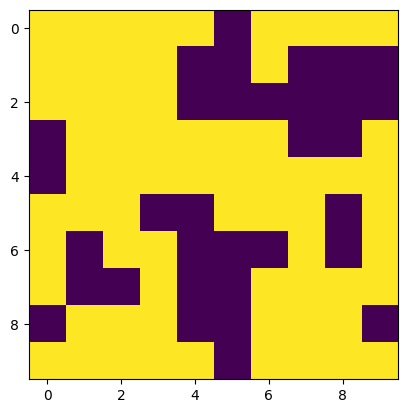

Evaluation 63 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.02it/s]


Completed. Saving
Time (s) to complete simulation 63: 0.8508484363555908


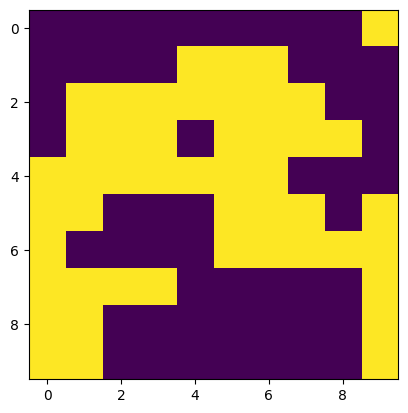

Evaluation 64 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.13it/s]


Completed. Saving
Time (s) to complete simulation 64: 0.8399479389190674


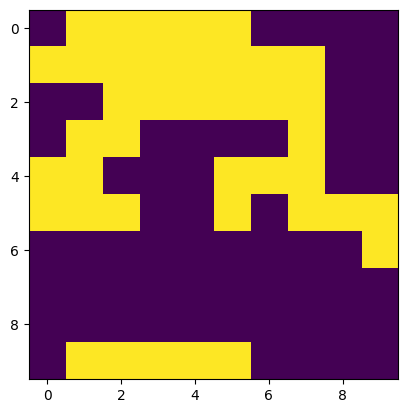

Evaluation 65 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.53it/s]


Completed. Saving
Time (s) to complete simulation 65: 0.8413689136505127


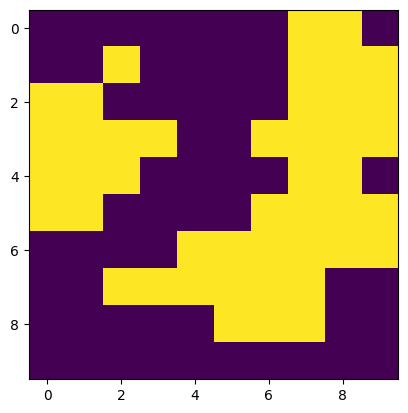

Evaluation 66 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 214.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.86it/s]


Completed. Saving
Time (s) to complete simulation 66: 0.855527400970459


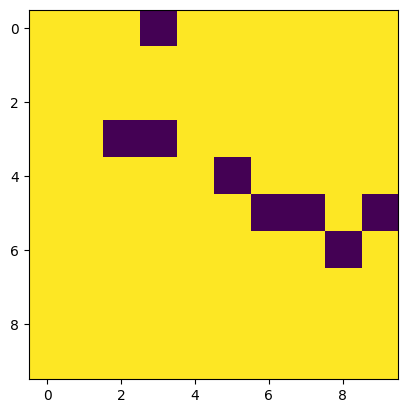

Evaluation 67 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 217.75it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.33it/s]


Completed. Saving
Time (s) to complete simulation 67: 0.8385875225067139


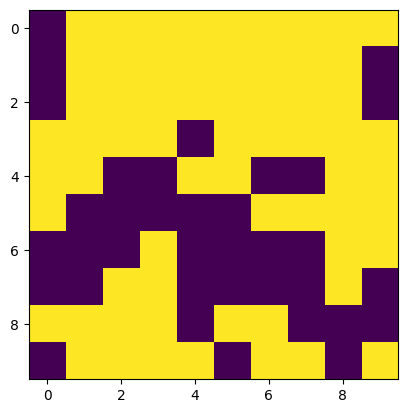

Evaluation 68 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.06it/s]


Completed. Saving
Time (s) to complete simulation 68: 0.8452045917510986


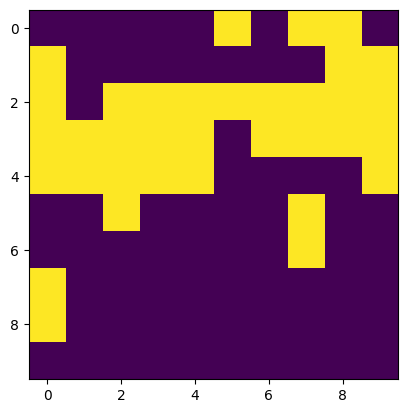

Evaluation 69 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.56it/s]


Completed. Saving
Time (s) to complete simulation 69: 0.8514399528503418


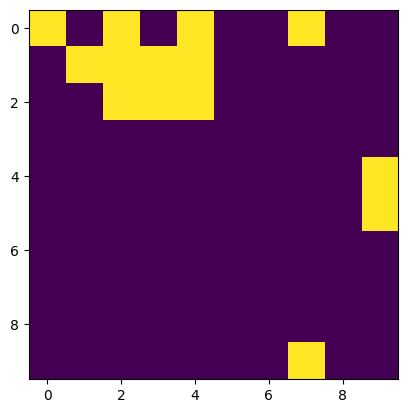

Evaluation 70 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.08it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.83it/s]


Completed. Saving
Time (s) to complete simulation 70: 0.861431360244751


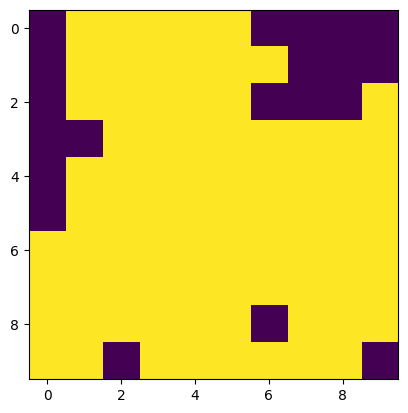

Evaluation 71 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.72it/s]


Completed. Saving
Time (s) to complete simulation 71: 1.3107662200927734


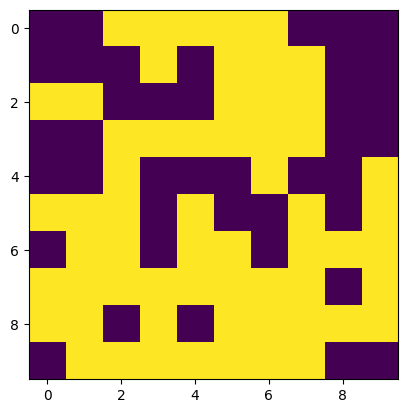

Evaluation 72 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 133.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 51.15it/s]


Completed. Saving
Time (s) to complete simulation 72: 1.374309778213501


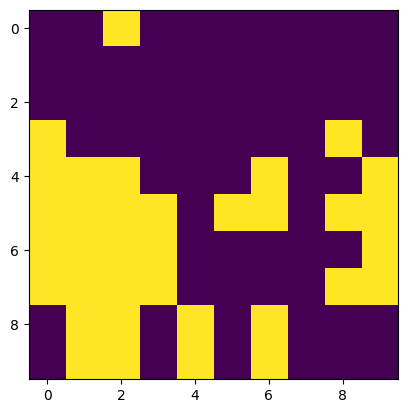

Evaluation 73 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.57it/s]


Completed. Saving
Time (s) to complete simulation 73: 0.8637540340423584


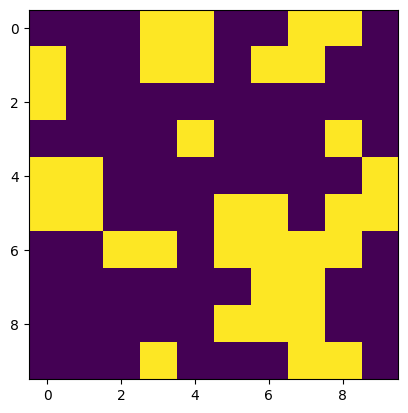

Evaluation 74 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.80it/s]


Completed. Saving
Time (s) to complete simulation 74: 0.8480236530303955


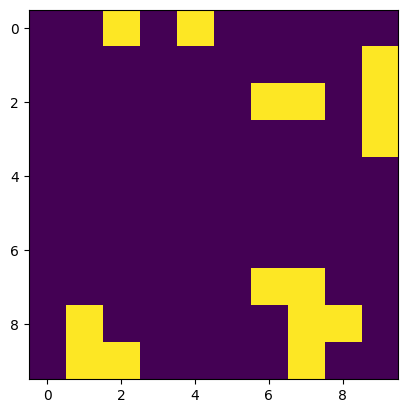

Evaluation 75 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.52it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.51it/s]


Completed. Saving
Time (s) to complete simulation 75: 0.8592205047607422


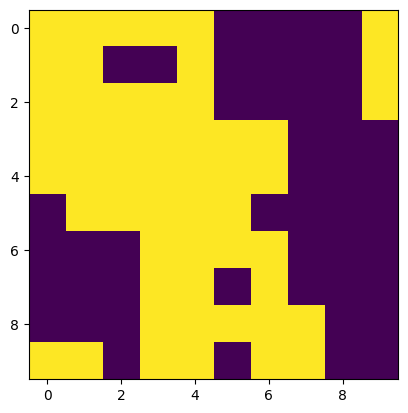

Evaluation 76 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.71it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.07it/s]


Completed. Saving
Time (s) to complete simulation 76: 0.8636646270751953


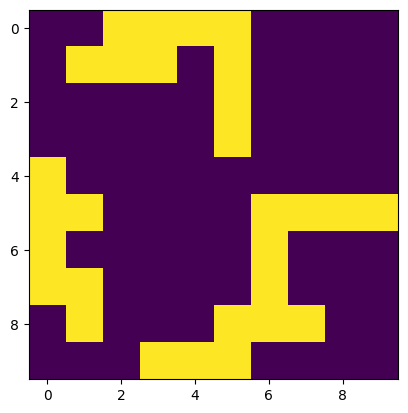

Evaluation 77 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 223.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 87.02it/s]


Completed. Saving
Time (s) to complete simulation 77: 0.8191745281219482


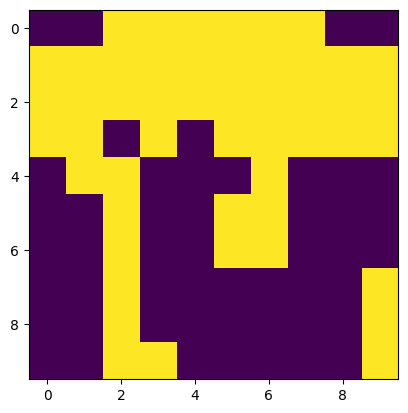

Evaluation 78 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.77it/s]


Completed. Saving
Time (s) to complete simulation 78: 0.830148458480835


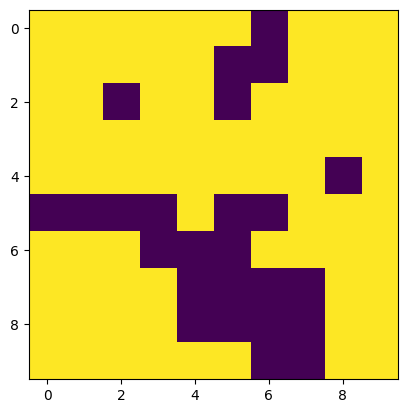

Evaluation 79 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 214.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.51it/s]


Completed. Saving
Time (s) to complete simulation 79: 0.8433322906494141


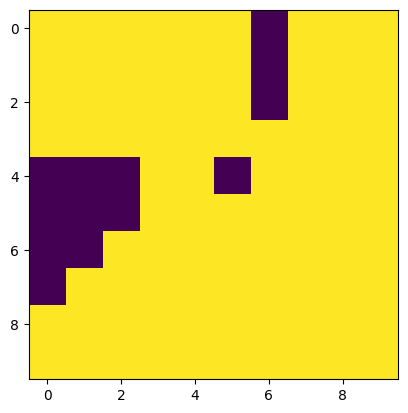

Evaluation 80 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 215.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.36it/s]


Completed. Saving
Time (s) to complete simulation 80: 0.8482992649078369


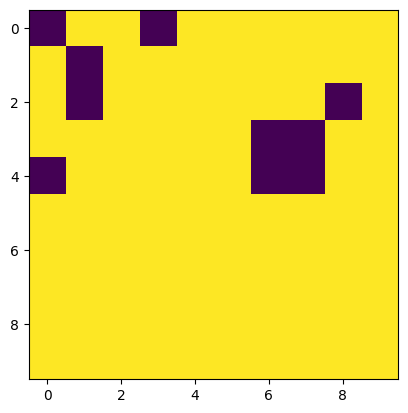

Evaluation 81 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 220.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.25it/s]


Completed. Saving
Time (s) to complete simulation 81: 0.8293192386627197


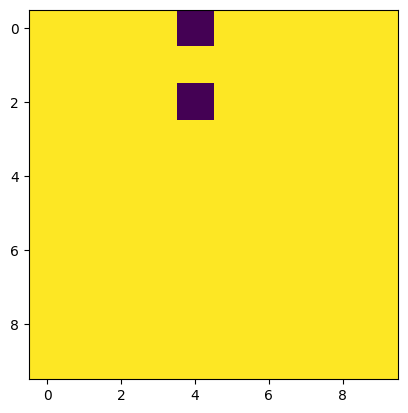

Evaluation 82 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.65it/s]


Completed. Saving
Time (s) to complete simulation 82: 1.3290719985961914


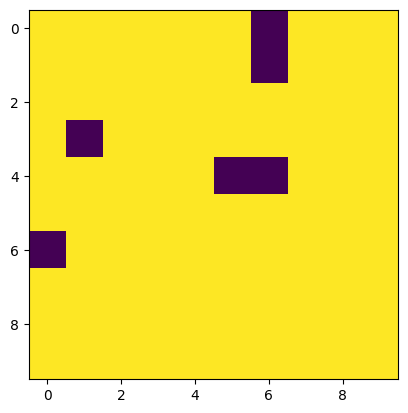

Evaluation 83 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.83it/s]


Completed. Saving
Time (s) to complete simulation 83: 1.3897149562835693


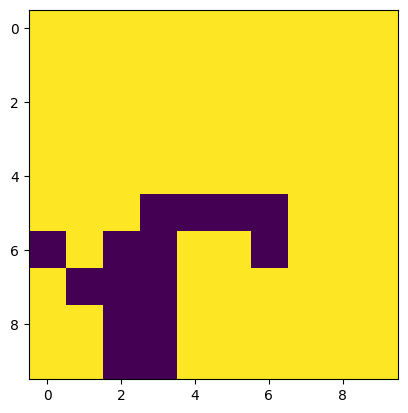

Evaluation 84 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.57it/s]


Completed. Saving
Time (s) to complete simulation 84: 0.8596634864807129


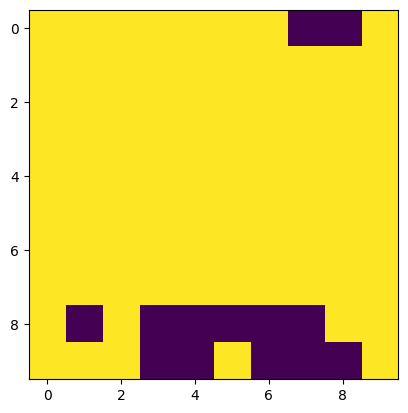

Evaluation 85 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.48it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 86.52it/s]


Completed. Saving
Time (s) to complete simulation 85: 0.8494706153869629


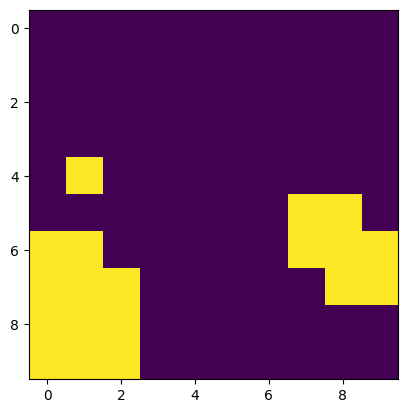

Evaluation 86 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.88it/s]


Completed. Saving
Time (s) to complete simulation 86: 0.848238468170166


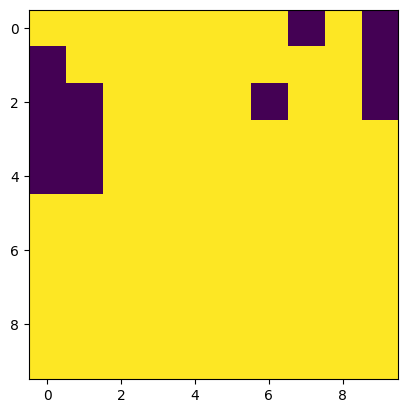

Evaluation 87 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.13it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.77it/s]


Completed. Saving
Time (s) to complete simulation 87: 0.8491096496582031


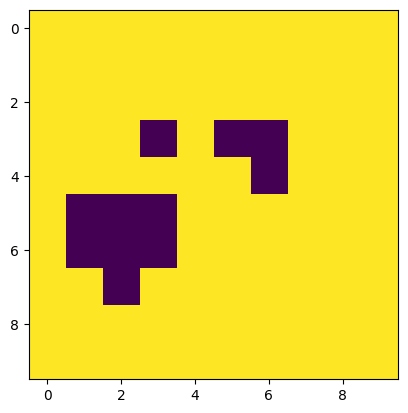

Evaluation 88 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.48it/s]


Completed. Saving
Time (s) to complete simulation 88: 0.8701300621032715


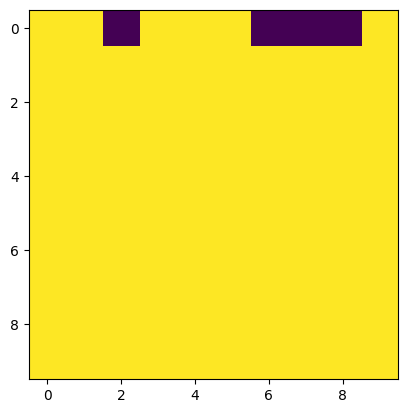

Evaluation 89 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.23it/s]


Completed. Saving
Time (s) to complete simulation 89: 0.8603057861328125


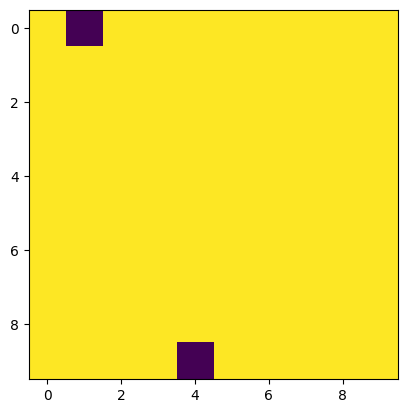

Evaluation 90 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.95it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 54.24it/s]


Completed. Saving
Time (s) to complete simulation 90: 1.178501844406128


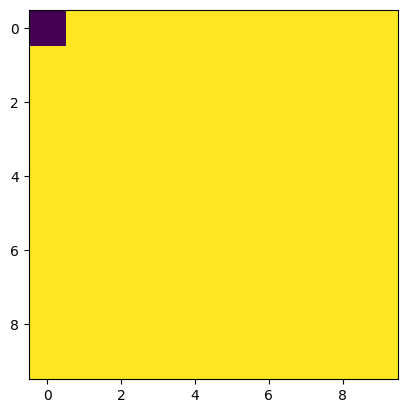

Evaluation 91 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.20it/s]


Completed. Saving
Time (s) to complete simulation 91: 0.8563590049743652


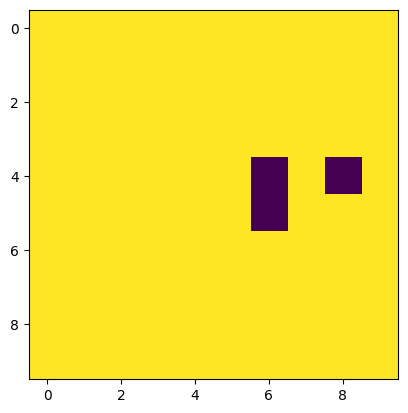

Evaluation 92 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.86it/s]


Completed. Saving
Time (s) to complete simulation 92: 0.876002311706543


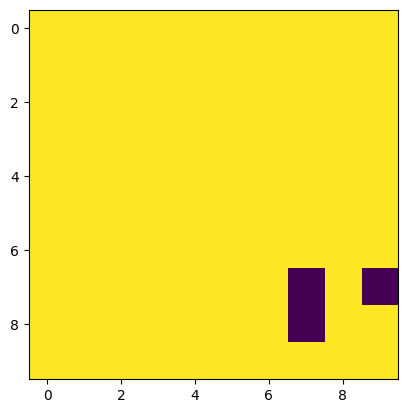

Evaluation 93 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 134.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 46.46it/s]


Completed. Saving
Time (s) to complete simulation 93: 1.466482162475586


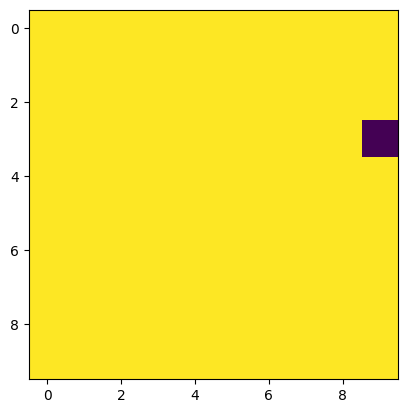

Evaluation 94 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 130.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.15it/s]


Completed. Saving
Time (s) to complete simulation 94: 1.4242596626281738


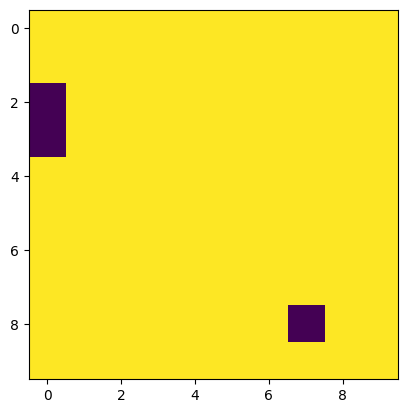

Evaluation 95 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 222.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 85.48it/s]


Completed. Saving
Time (s) to complete simulation 95: 0.8317794799804688


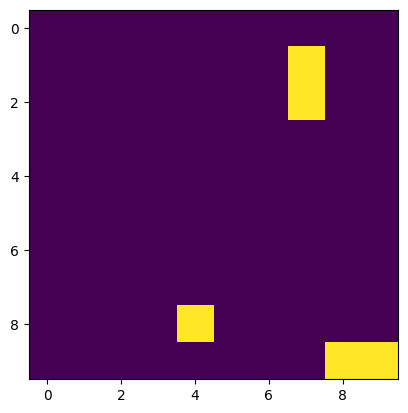

Evaluation 96 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.07it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.96it/s]


Completed. Saving
Time (s) to complete simulation 96: 0.8413050174713135


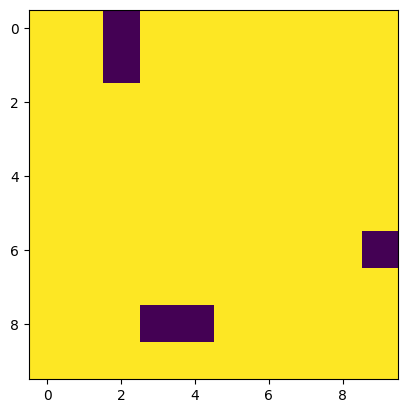

Evaluation 97 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 56.74it/s]


Completed. Saving
Time (s) to complete simulation 97: 1.1480937004089355


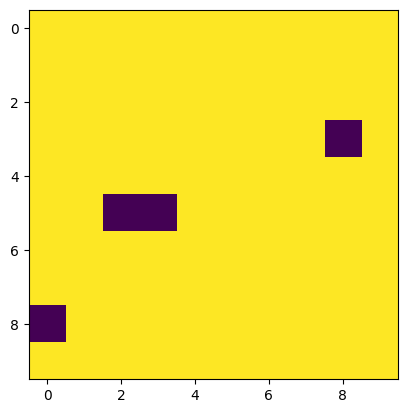

Evaluation 98 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 108.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 66.04it/s]


Completed. Saving
Time (s) to complete simulation 98: 1.2650320529937744


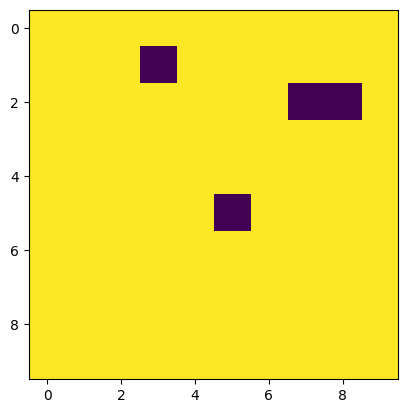

Evaluation 99 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.47it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.65it/s]


Completed. Saving
Time (s) to complete simulation 99: 0.8651511669158936


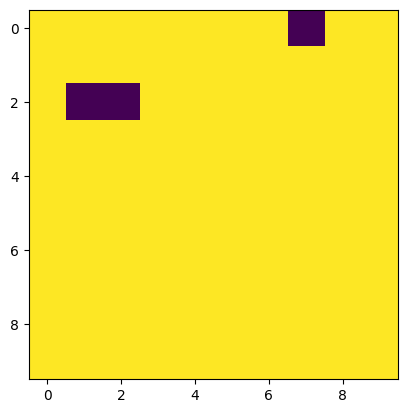

Evaluation 100 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.84it/s]


Completed. Saving
Time (s) to complete simulation 100: 0.8414125442504883


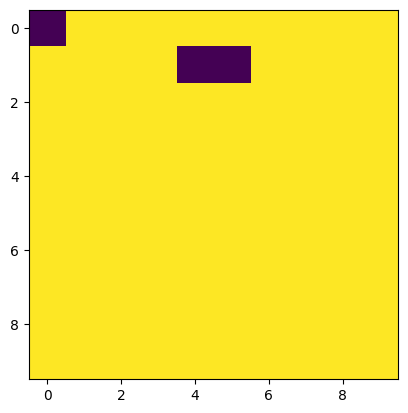

Evaluation 101 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 209.77it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.97it/s]


Completed. Saving
Time (s) to complete simulation 101: 0.8536739349365234


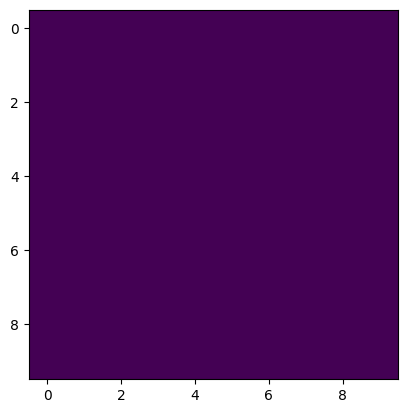

Evaluation 102 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.40it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.36it/s]


Completed. Saving
Time (s) to complete simulation 102: 0.8687171936035156


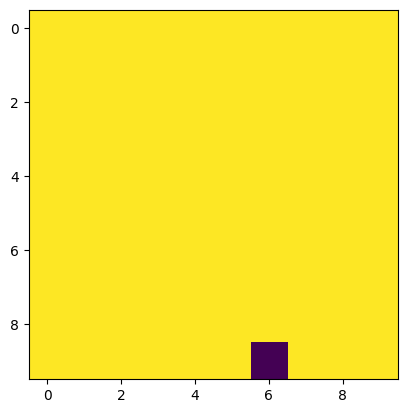

Evaluation 103 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.25it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 50.11it/s]


Completed. Saving
Time (s) to complete simulation 103: 1.2653064727783203


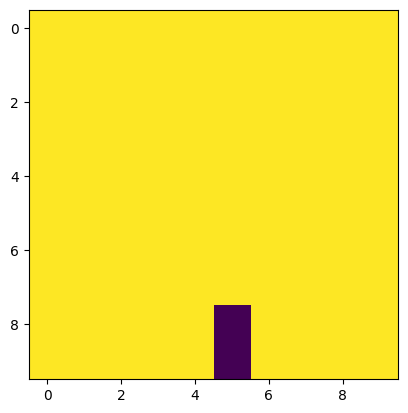

Evaluation 104 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 138.69it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.18it/s]


Completed. Saving
Time (s) to complete simulation 104: 1.4165771007537842


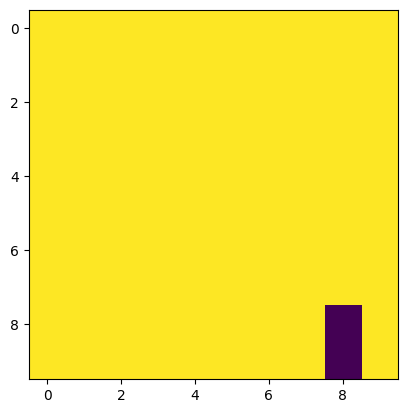

Evaluation 105 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 174.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.64it/s]


Completed. Saving
Time (s) to complete simulation 105: 0.9049375057220459


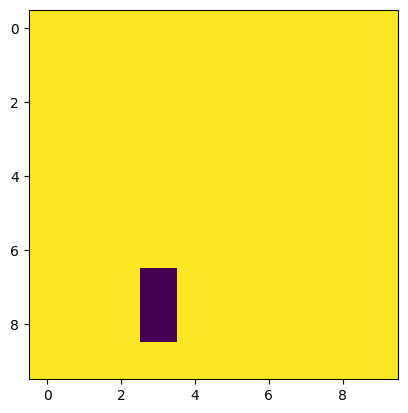

Evaluation 106 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.07it/s]


Completed. Saving
Time (s) to complete simulation 106: 0.8750321865081787


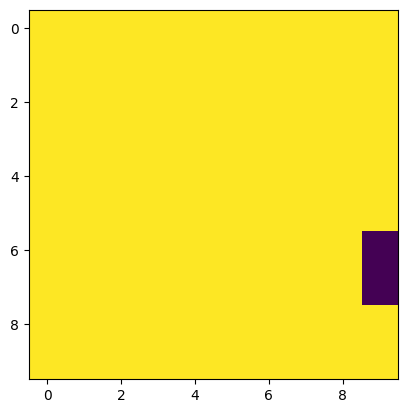

Evaluation 107 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 203.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.35it/s]


Completed. Saving
Time (s) to complete simulation 107: 0.8823559284210205


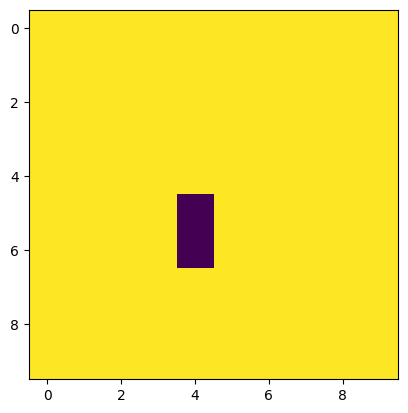

Evaluation 108 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 211.60it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.37it/s]


Completed. Saving
Time (s) to complete simulation 108: 0.867734432220459


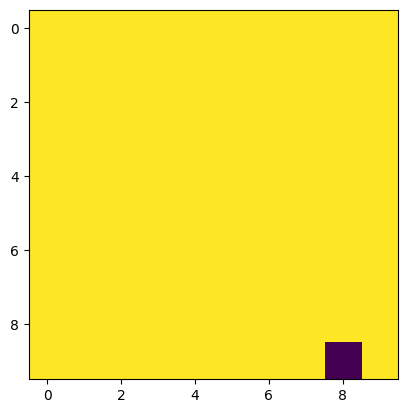

Evaluation 109 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 207.82it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.64it/s]


Completed. Saving
Time (s) to complete simulation 109: 0.8702075481414795


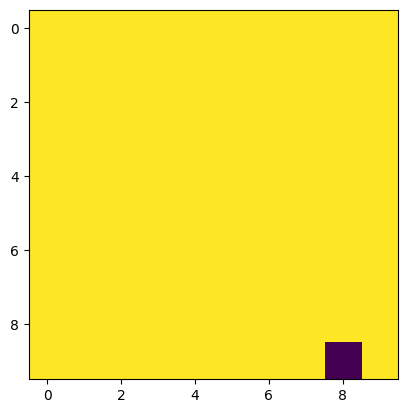

Evaluation 110 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.22it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.23it/s]


Completed. Saving
Time (s) to complete simulation 110: 1.218693494796753


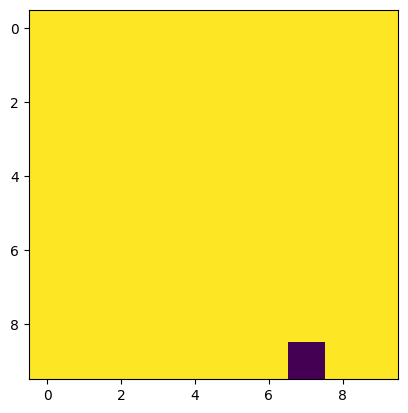

Evaluation 111 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.42it/s]


Completed. Saving
Time (s) to complete simulation 111: 0.9000601768493652


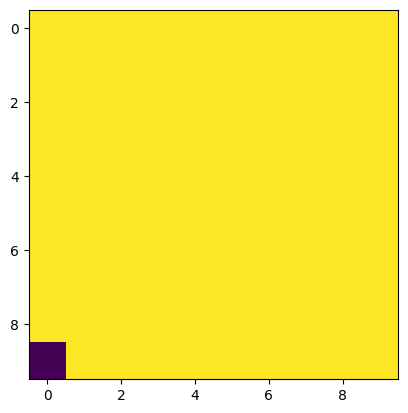

Evaluation 112 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.53it/s]


Completed. Saving
Time (s) to complete simulation 112: 0.8788595199584961


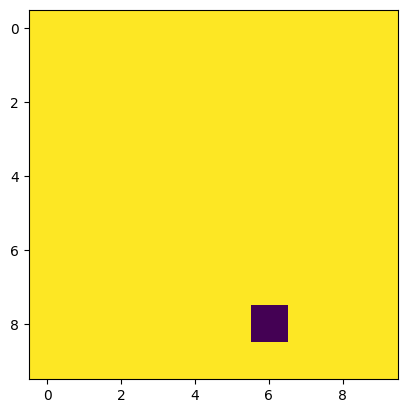

Evaluation 113 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 70.35it/s]


Completed. Saving
Time (s) to complete simulation 113: 0.9763429164886475


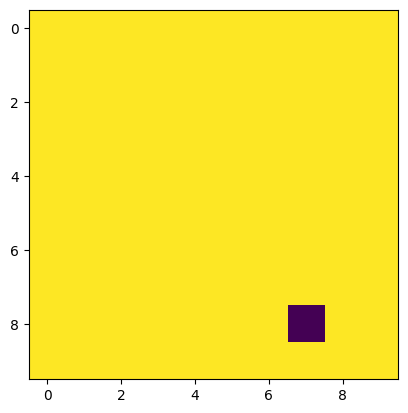

Evaluation 114 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 116.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.29it/s]


Completed. Saving
Time (s) to complete simulation 114: 1.4637787342071533


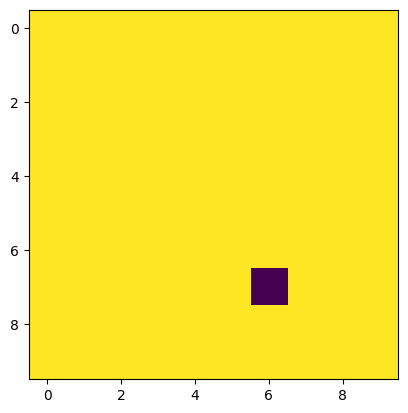

Evaluation 115 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 129.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.15it/s]


Completed. Saving
Time (s) to complete simulation 115: 1.1002943515777588


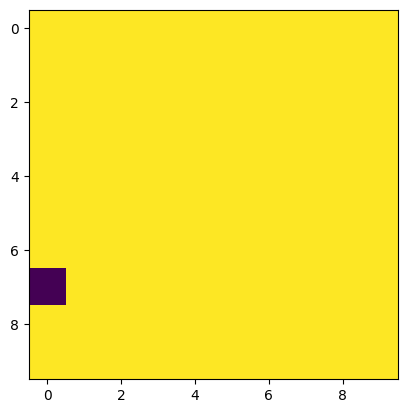

Evaluation 116 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 200.21it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.62it/s]


Completed. Saving
Time (s) to complete simulation 116: 0.896160364151001


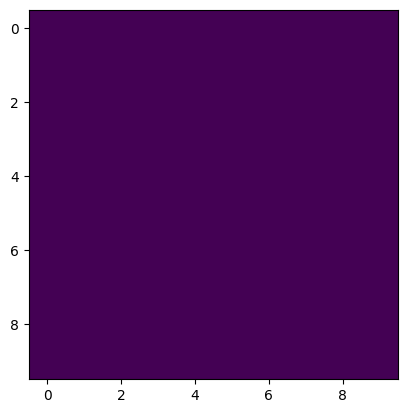

Evaluation 117 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.36it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.21it/s]


Completed. Saving
Time (s) to complete simulation 117: 0.8723907470703125


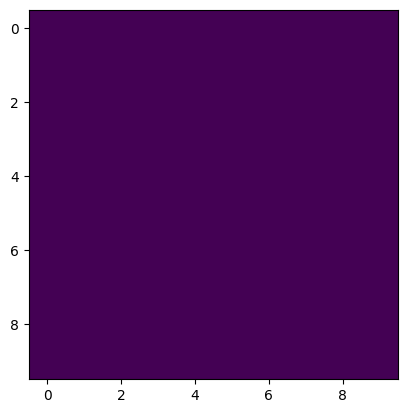

Evaluation 118 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.13it/s]


Completed. Saving
Time (s) to complete simulation 118: 0.909583330154419


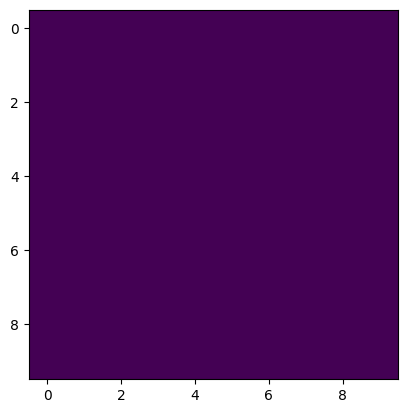

Evaluation 119 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.43it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 84.41it/s]


Completed. Saving
Time (s) to complete simulation 119: 0.8559949398040771


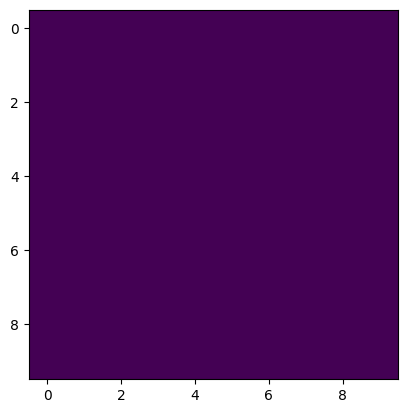

Evaluation 120 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.62it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.98it/s]


Completed. Saving
Time (s) to complete simulation 120: 0.8898646831512451


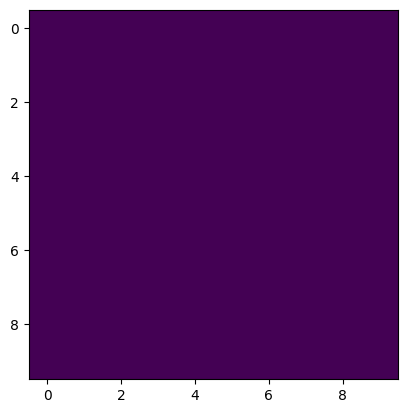

Evaluation 121 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 210.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.84it/s]


Completed. Saving
Time (s) to complete simulation 121: 0.8501121997833252


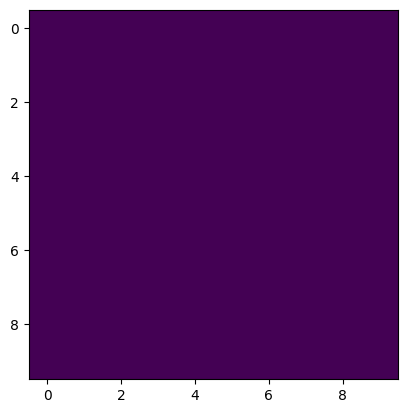

Evaluation 122 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 212.66it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.55it/s]


Completed. Saving
Time (s) to complete simulation 122: 0.8607833385467529


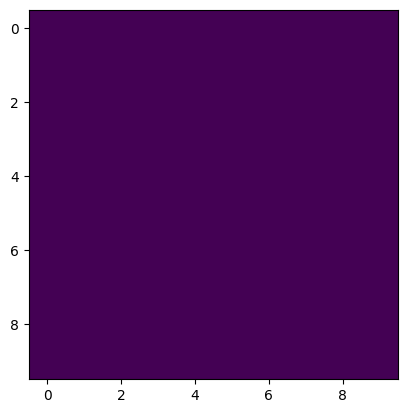

Evaluation 123 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.81it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 83.22it/s]


Completed. Saving
Time (s) to complete simulation 123: 0.8596954345703125


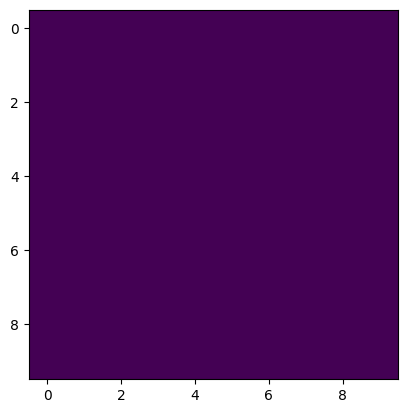

Evaluation 124 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 196.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 63.38it/s]


Completed. Saving
Time (s) to complete simulation 124: 1.0620214939117432


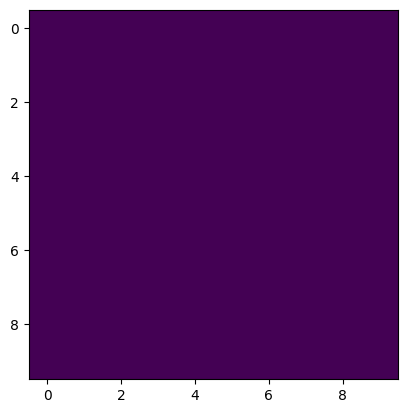

Evaluation 125 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 106.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 46.04it/s]


Completed. Saving
Time (s) to complete simulation 125: 1.5731837749481201


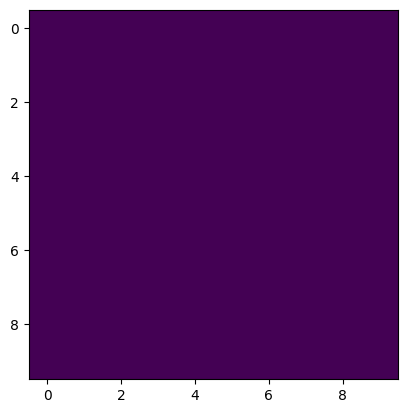

Evaluation 126 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 123.78it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 68.45it/s]


Completed. Saving
Time (s) to complete simulation 126: 1.1515817642211914


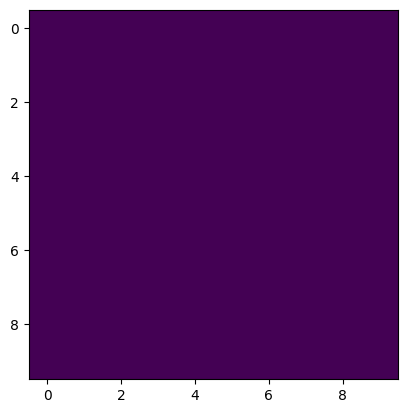

Evaluation 127 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 205.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.88it/s]


Completed. Saving
Time (s) to complete simulation 127: 0.8937423229217529


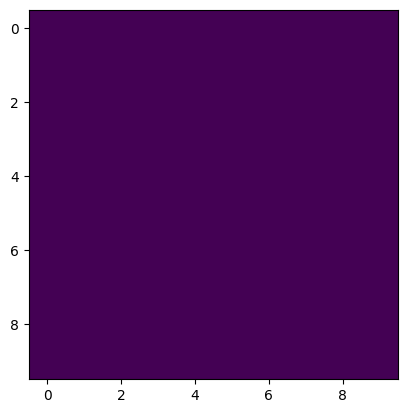

Evaluation 128 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 208.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.63it/s]


Completed. Saving
Time (s) to complete simulation 128: 0.9089312553405762


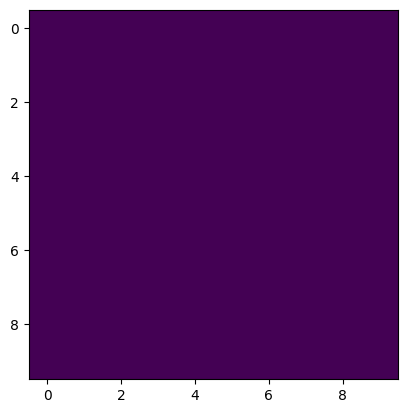

Evaluation 129 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 202.37it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.99it/s]


Completed. Saving
Time (s) to complete simulation 129: 0.8953104019165039


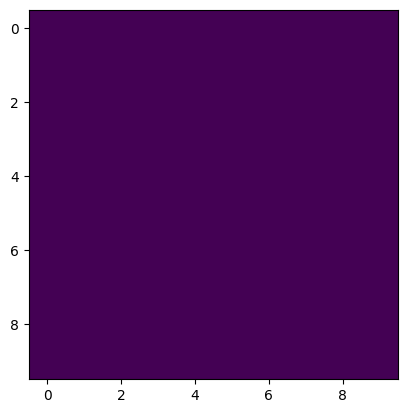

Evaluation 130 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.87it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.27it/s]


Completed. Saving
Time (s) to complete simulation 130: 0.8909070491790771


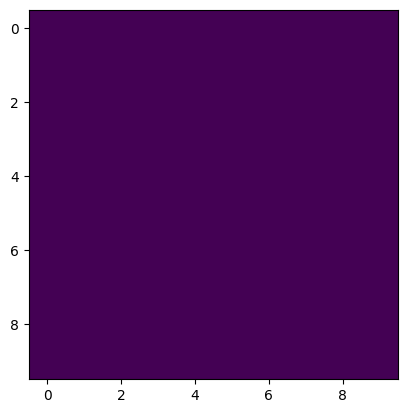

Evaluation 131 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.16it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.99it/s]


Completed. Saving
Time (s) to complete simulation 131: 0.8823635578155518


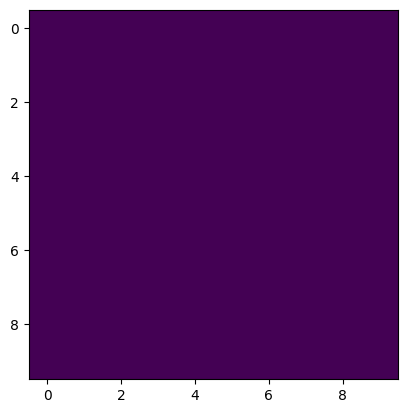

Evaluation 132 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.00it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.88it/s]


Completed. Saving
Time (s) to complete simulation 132: 0.8781819343566895


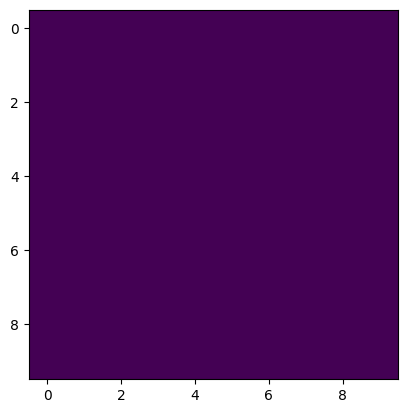

Evaluation 133 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 183.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 82.58it/s]


Completed. Saving
Time (s) to complete simulation 133: 0.8963229656219482


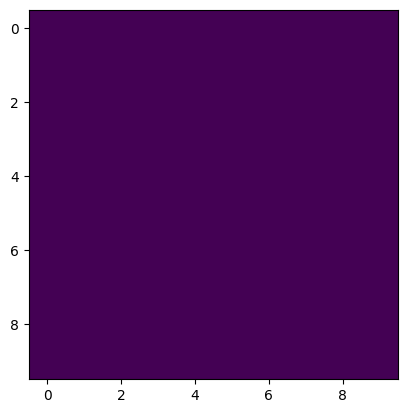

Evaluation 134 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.68it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.99it/s]


Completed. Saving
Time (s) to complete simulation 134: 0.8953173160552979


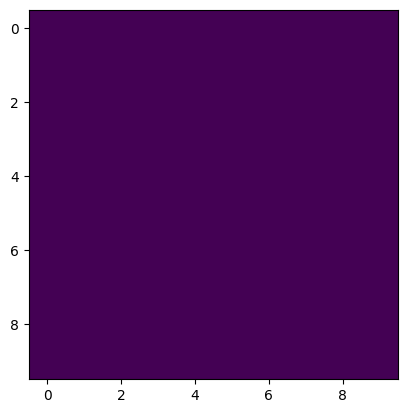

Evaluation 135 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.35it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.51it/s]


Completed. Saving
Time (s) to complete simulation 135: 1.2211663722991943


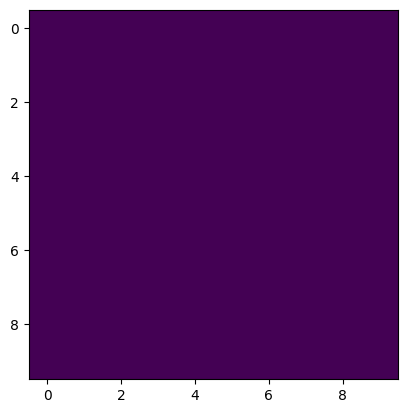

Evaluation 136 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 124.38it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.13it/s]


Completed. Saving
Time (s) to complete simulation 136: 1.4538350105285645


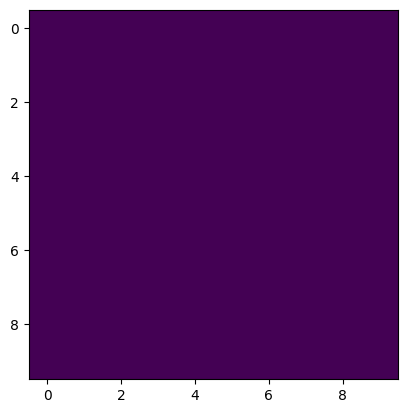

Evaluation 137 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 145.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.59it/s]


Completed. Saving
Time (s) to complete simulation 137: 0.9868147373199463


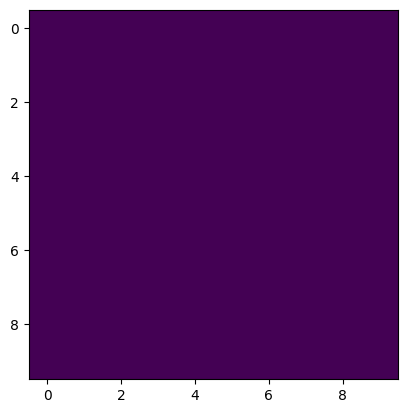

Evaluation 138 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 194.06it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.01it/s]


Completed. Saving
Time (s) to complete simulation 138: 0.9335241317749023


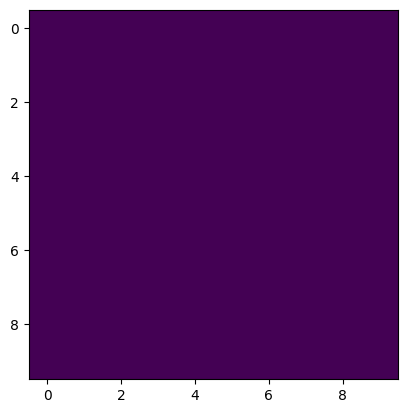

Evaluation 139 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.91it/s]


Completed. Saving
Time (s) to complete simulation 139: 0.9011540412902832


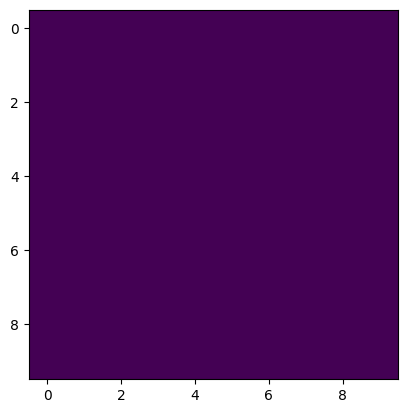

Evaluation 140 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 184.98it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.24it/s]


Completed. Saving
Time (s) to complete simulation 140: 0.9011611938476562


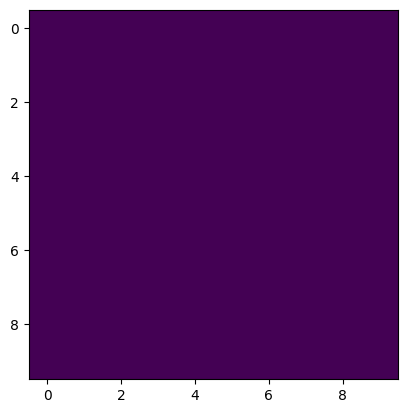

Evaluation 141 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 182.02it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.07it/s]


Completed. Saving
Time (s) to complete simulation 141: 0.9259834289550781


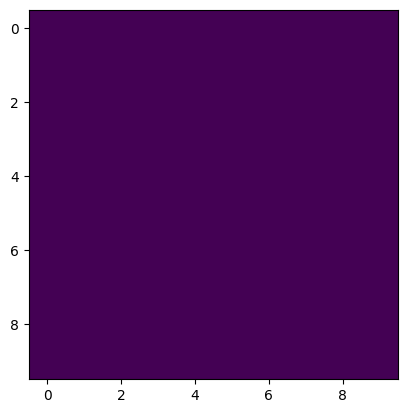

Evaluation 142 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 197.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.18it/s]


Completed. Saving
Time (s) to complete simulation 142: 0.9007506370544434


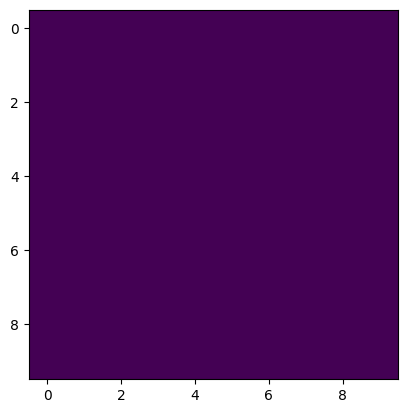

Evaluation 143 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.50it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.43it/s]


Completed. Saving
Time (s) to complete simulation 143: 0.9339923858642578


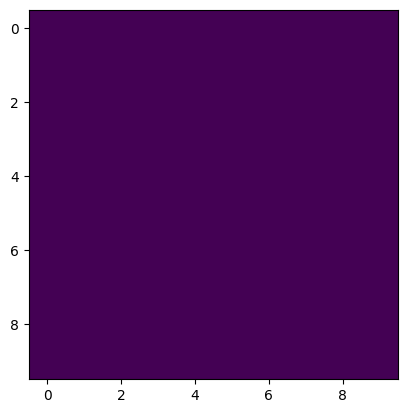

Evaluation 144 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.80it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.99it/s]


Completed. Saving
Time (s) to complete simulation 144: 0.9003047943115234


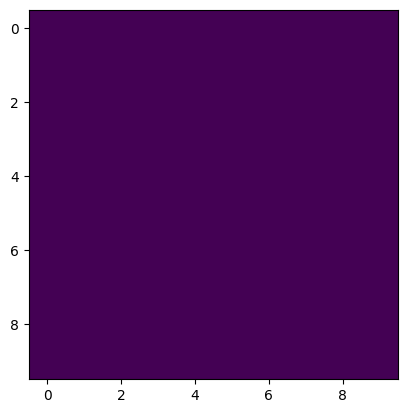

Evaluation 145 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.54it/s]


Completed. Saving
Time (s) to complete simulation 145: 0.8939545154571533


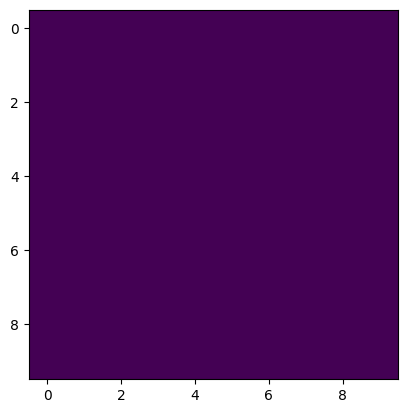

Evaluation 146 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 131.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 45.06it/s]


Completed. Saving
Time (s) to complete simulation 146: 1.5086395740509033


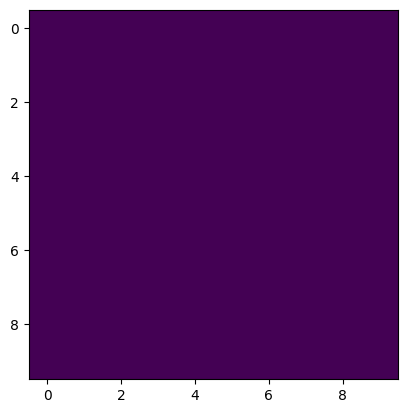

Evaluation 147 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 121.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 49.34it/s]


Completed. Saving
Time (s) to complete simulation 147: 1.4466779232025146


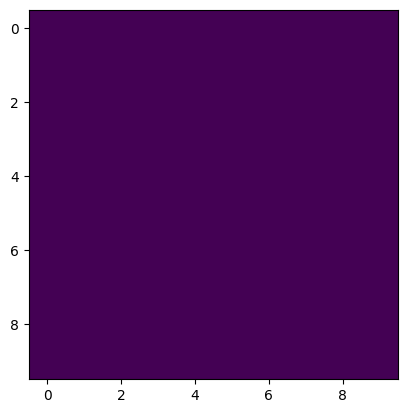

Evaluation 148 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.62it/s]


Completed. Saving
Time (s) to complete simulation 148: 0.9011311531066895


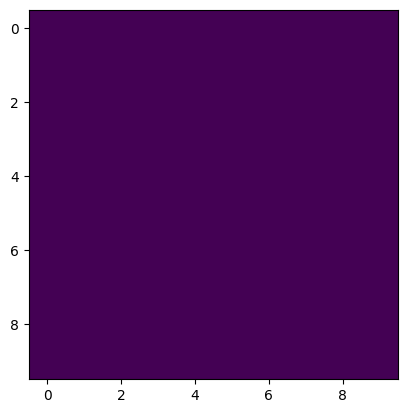

Evaluation 149 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.94it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.81it/s]


Completed. Saving
Time (s) to complete simulation 149: 0.8957095146179199


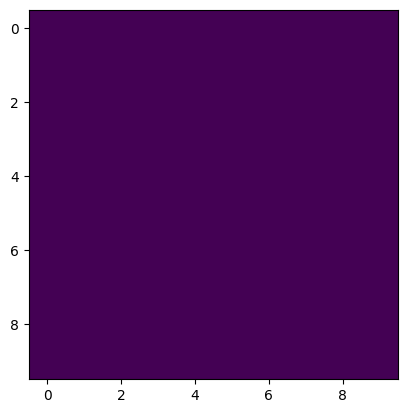

Evaluation 150 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.04it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.19it/s]


Completed. Saving
Time (s) to complete simulation 150: 0.8978104591369629


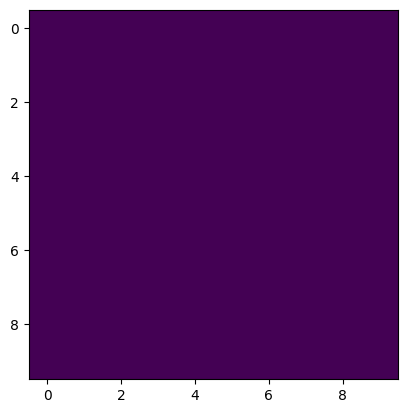

Evaluation 151 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.72it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.95it/s]


Completed. Saving
Time (s) to complete simulation 151: 0.9323029518127441


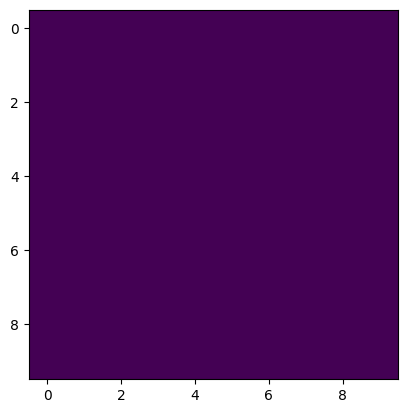

Evaluation 152 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 206.28it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.27it/s]


Completed. Saving
Time (s) to complete simulation 152: 0.8893556594848633


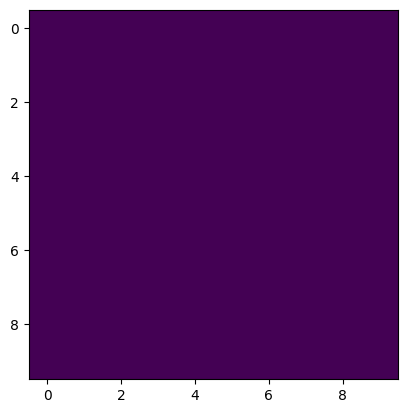

Evaluation 153 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.91it/s]


Completed. Saving
Time (s) to complete simulation 153: 0.8973629474639893


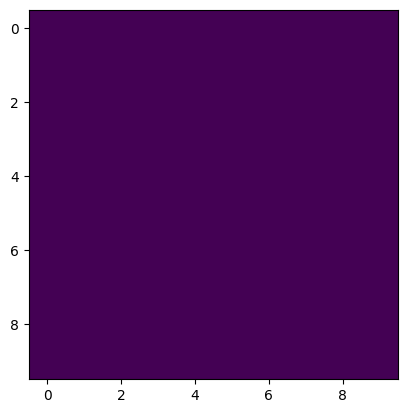

Evaluation 154 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 193.65it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 81.92it/s]


Completed. Saving
Time (s) to complete simulation 154: 0.8890719413757324


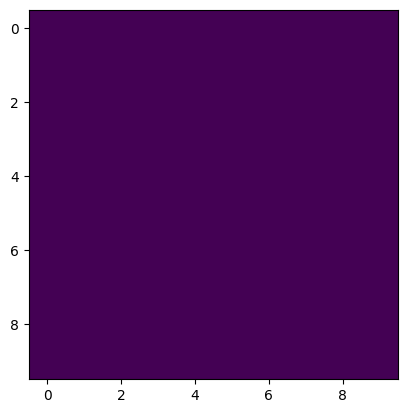

Evaluation 155 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.53it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.31it/s]


Completed. Saving
Time (s) to complete simulation 155: 0.8992018699645996


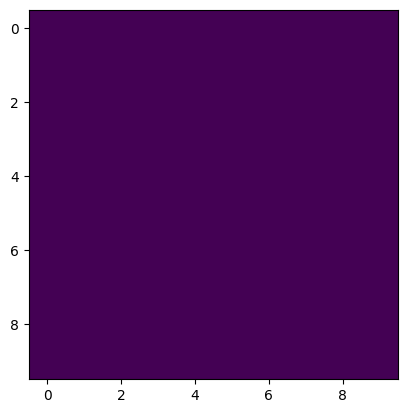

Evaluation 156 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 204.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 64.88it/s]


Completed. Saving
Time (s) to complete simulation 156: 1.035447359085083


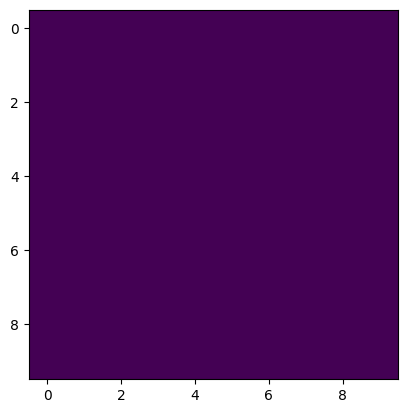

Evaluation 157 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 115.99it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 46.61it/s]


Completed. Saving
Time (s) to complete simulation 157: 1.5242600440979004


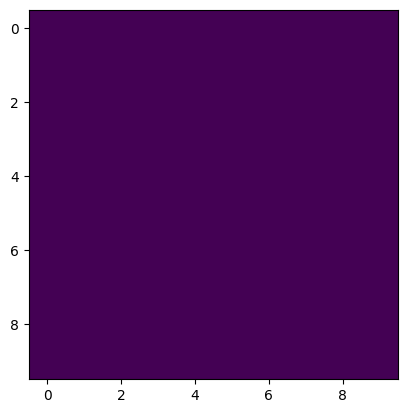

Evaluation 158 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.92it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 63.64it/s]


Completed. Saving
Time (s) to complete simulation 158: 1.2062225341796875


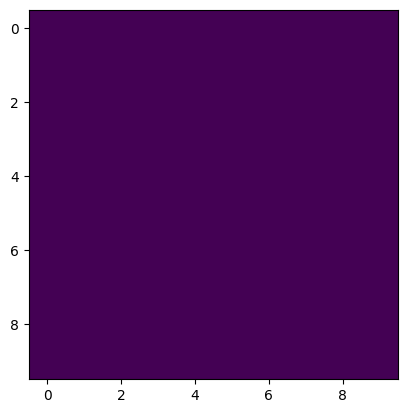

Evaluation 159 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 191.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.67it/s]


Completed. Saving
Time (s) to complete simulation 159: 0.9115946292877197


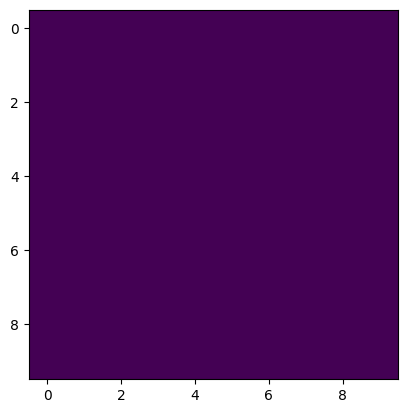

Evaluation 160 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 201.84it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.68it/s]


Completed. Saving
Time (s) to complete simulation 160: 0.9032111167907715


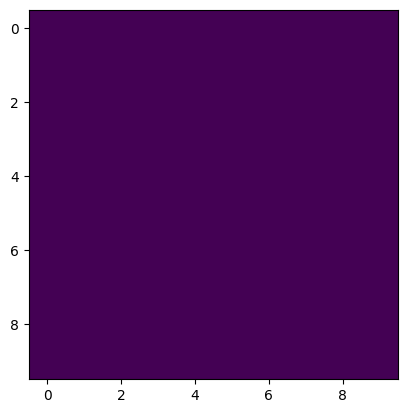

Evaluation 161 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.86it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.69it/s]


Completed. Saving
Time (s) to complete simulation 161: 0.9201836585998535


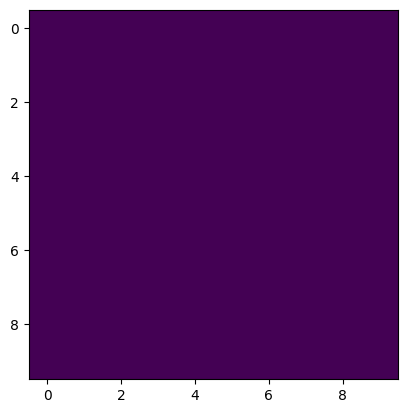

Evaluation 162 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.67it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.33it/s]


Completed. Saving
Time (s) to complete simulation 162: 0.9193494319915771


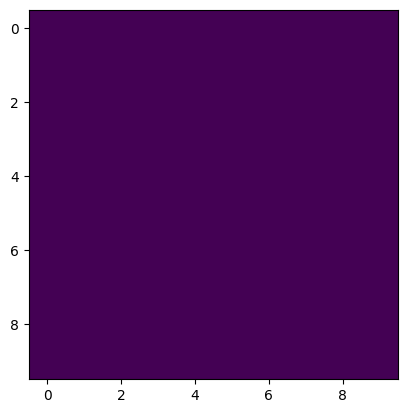

Evaluation 163 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 181.49it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.03it/s]


Completed. Saving
Time (s) to complete simulation 163: 0.9169023036956787


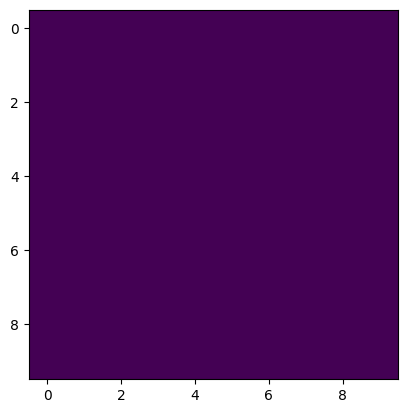

Evaluation 164 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 182.70it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.70it/s]


Completed. Saving
Time (s) to complete simulation 164: 0.9127533435821533


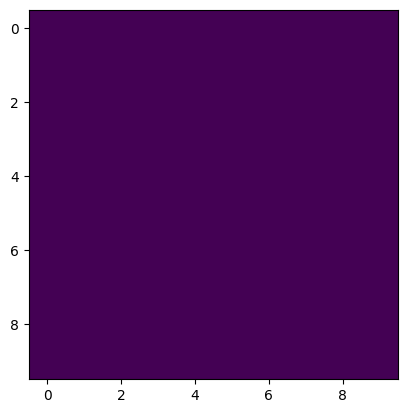

Evaluation 165 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.75it/s]


Completed. Saving
Time (s) to complete simulation 165: 0.921900749206543


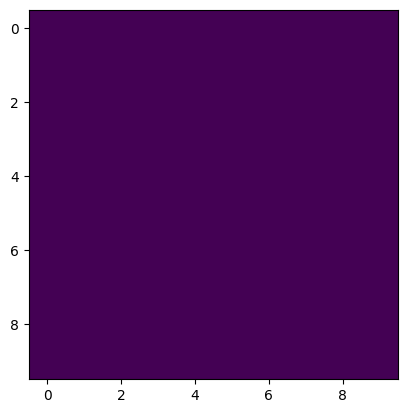

Evaluation 166 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 198.73it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.03it/s]


Completed. Saving
Time (s) to complete simulation 166: 0.9188919067382812


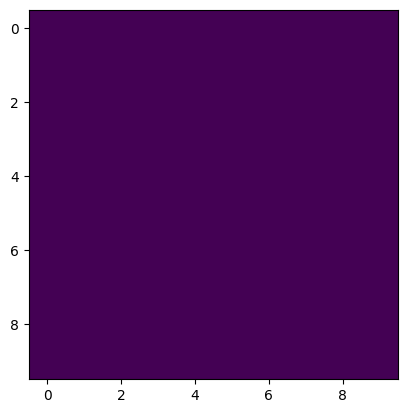

Evaluation 167 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 168.19it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 44.89it/s]


Completed. Saving
Time (s) to complete simulation 167: 1.4371888637542725


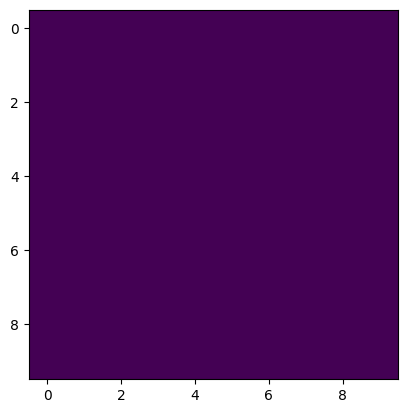

Evaluation 168 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 120.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 46.95it/s]


Completed. Saving
Time (s) to complete simulation 168: 1.5027003288269043


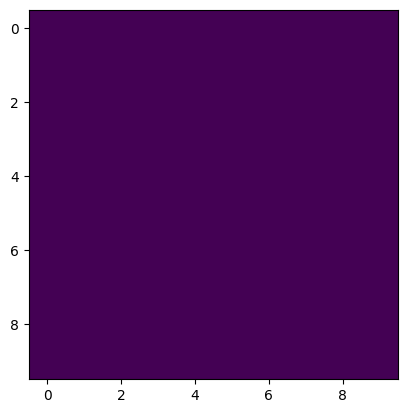

Evaluation 169 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 121.57it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 66.58it/s]


Completed. Saving
Time (s) to complete simulation 169: 1.184807538986206


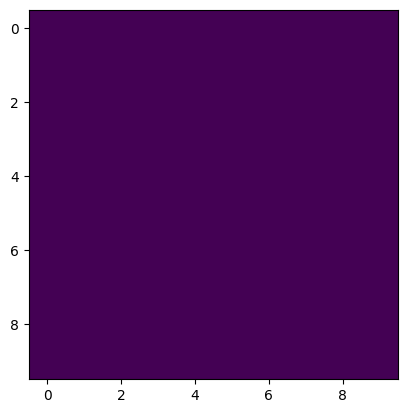

Evaluation 170 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 78.36it/s]


Completed. Saving
Time (s) to complete simulation 170: 0.9270930290222168


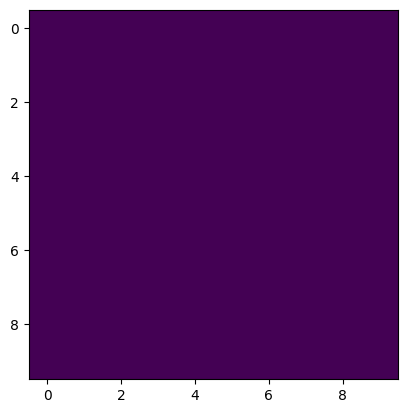

Evaluation 171 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 199.76it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.78it/s]


Completed. Saving
Time (s) to complete simulation 171: 0.9190452098846436


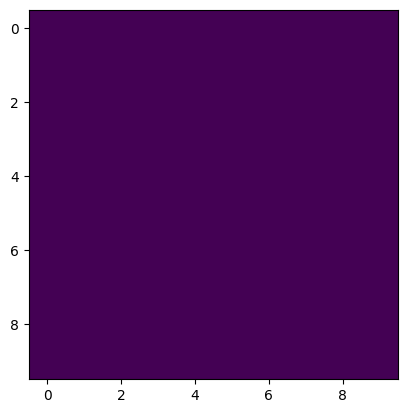

Evaluation 172 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 74.46it/s]


Completed. Saving
Time (s) to complete simulation 172: 0.949371337890625


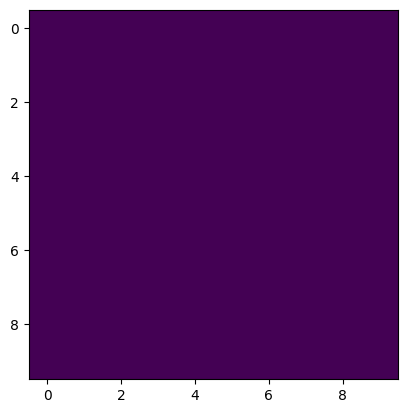

Evaluation 173 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.92it/s]


Completed. Saving
Time (s) to complete simulation 173: 0.9469969272613525


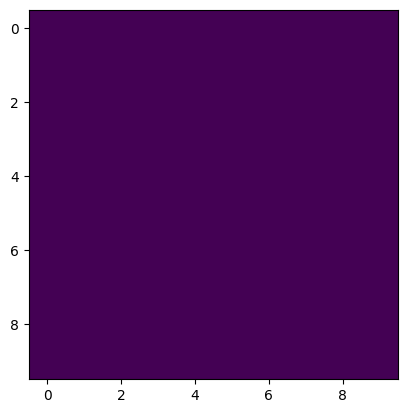

Evaluation 174 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.09it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.84it/s]


Completed. Saving
Time (s) to complete simulation 174: 0.9505023956298828


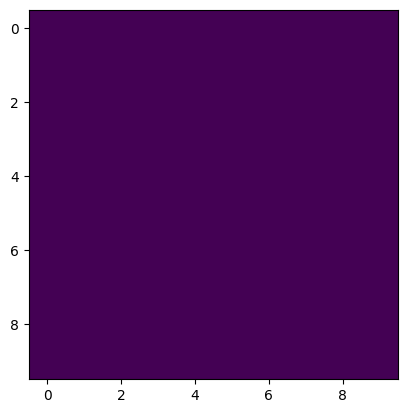

Evaluation 175 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 192.63it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.72it/s]


Completed. Saving
Time (s) to complete simulation 175: 0.9258432388305664


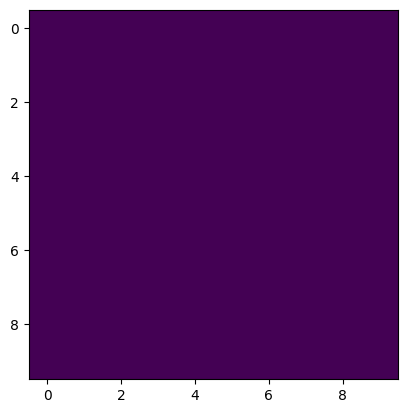

Evaluation 176 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 187.29it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 77.76it/s]


Completed. Saving
Time (s) to complete simulation 176: 0.9346215724945068


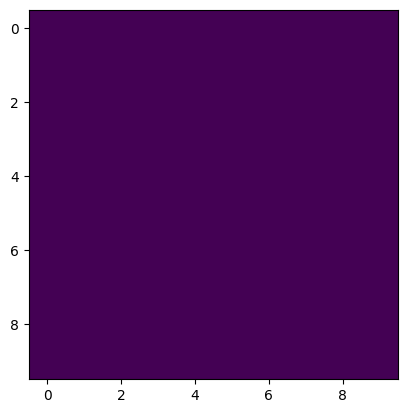

Evaluation 177 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.59it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 52.43it/s]


Completed. Saving
Time (s) to complete simulation 177: 1.23740816116333


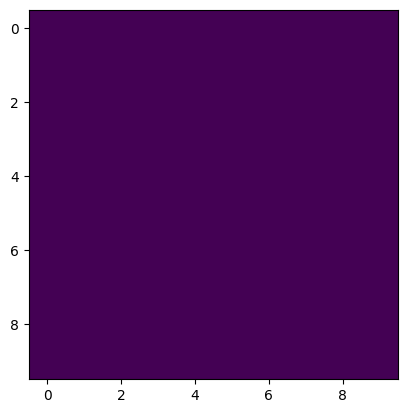

Evaluation 178 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 136.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.83it/s]


Completed. Saving
Time (s) to complete simulation 178: 1.4275245666503906


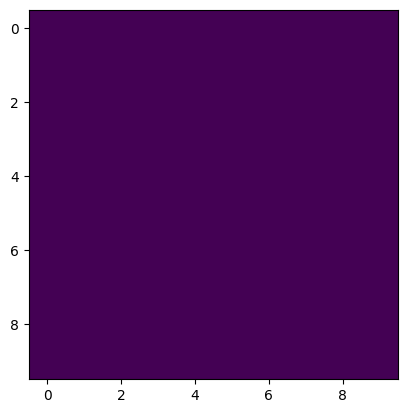

Evaluation 179 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 126.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 60.99it/s]


Completed. Saving
Time (s) to complete simulation 179: 1.2310106754302979


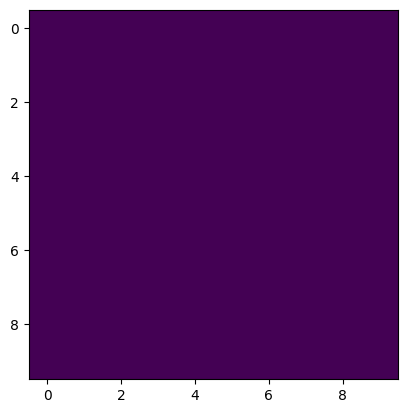

Evaluation 180 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.64it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.31it/s]


Completed. Saving
Time (s) to complete simulation 180: 0.9476006031036377


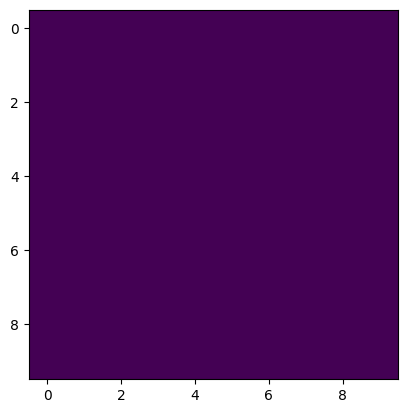

Evaluation 181 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.31it/s]


Completed. Saving
Time (s) to complete simulation 181: 0.9564077854156494


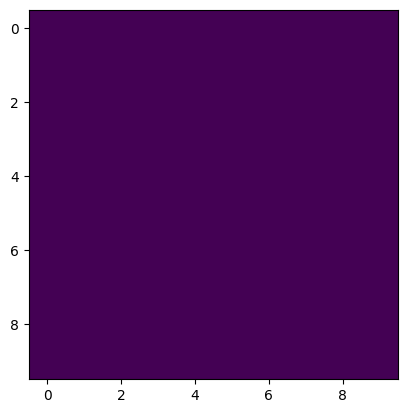

Evaluation 182 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 170.45it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.00it/s]


Completed. Saving
Time (s) to complete simulation 182: 0.9451029300689697


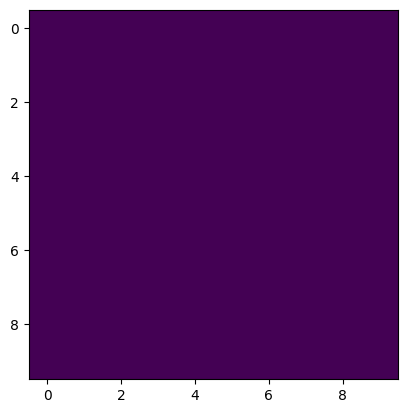

Evaluation 183 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 172.89it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 79.79it/s]


Completed. Saving
Time (s) to complete simulation 183: 0.9333920478820801


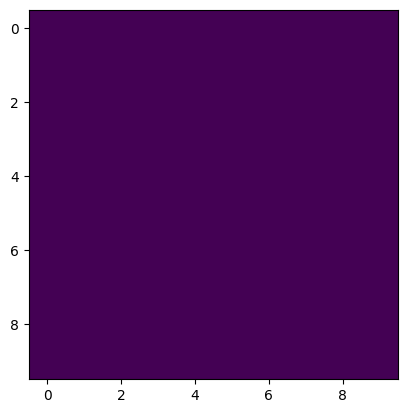

Evaluation 184 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 176.18it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.68it/s]


Completed. Saving
Time (s) to complete simulation 184: 0.9236710071563721


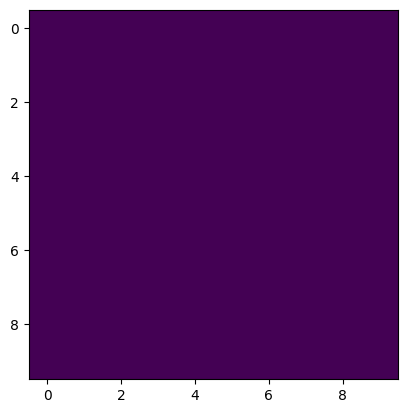

Evaluation 185 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 188.14it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 75.95it/s]


Completed. Saving
Time (s) to complete simulation 185: 0.9424166679382324


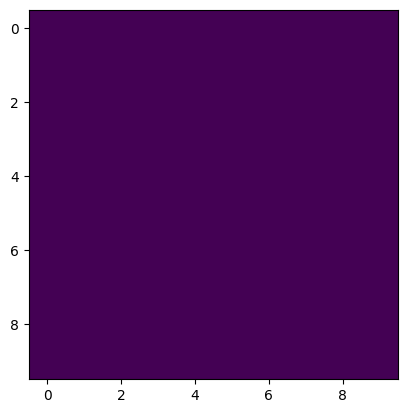

Evaluation 186 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 195.03it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 76.41it/s]


Completed. Saving
Time (s) to complete simulation 186: 0.9265158176422119


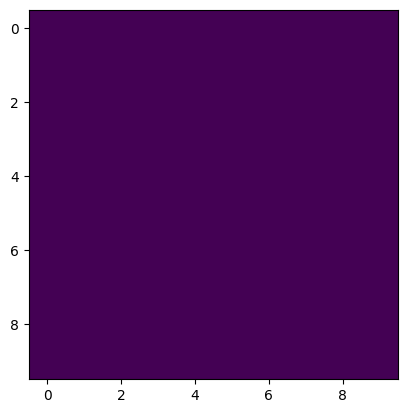

Evaluation 187 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.59it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.96it/s]


Completed. Saving
Time (s) to complete simulation 187: 0.9565215110778809


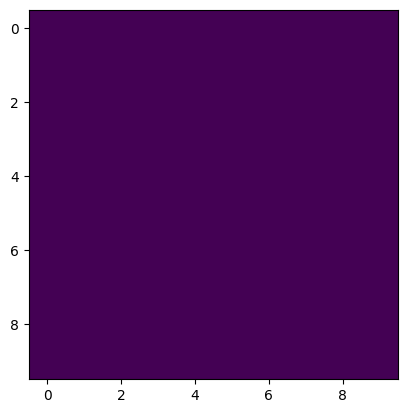

Evaluation 188 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 132.51it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 47.91it/s]


Completed. Saving
Time (s) to complete simulation 188: 1.4450478553771973


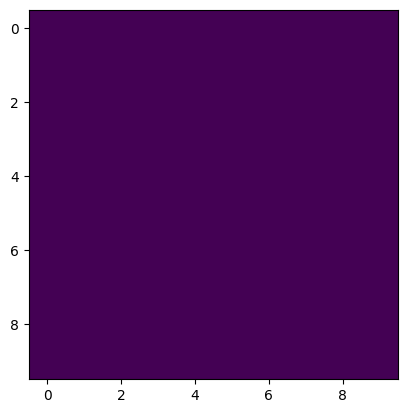

Evaluation 189 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 114.55it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 48.01it/s]


Completed. Saving
Time (s) to complete simulation 189: 1.4997003078460693


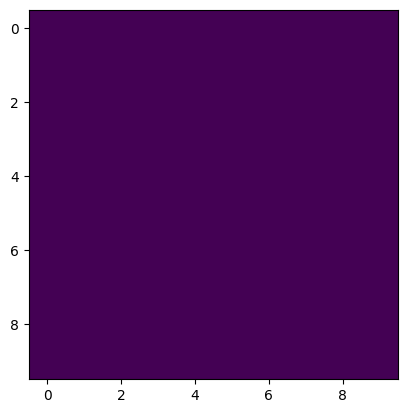

Evaluation 190 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 128.32it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 80.03it/s]


Completed. Saving
Time (s) to complete simulation 190: 1.0311498641967773


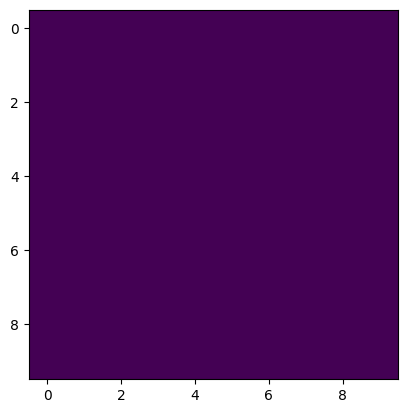

Evaluation 191 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 189.74it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 71.78it/s]


Completed. Saving
Time (s) to complete simulation 191: 0.981997013092041


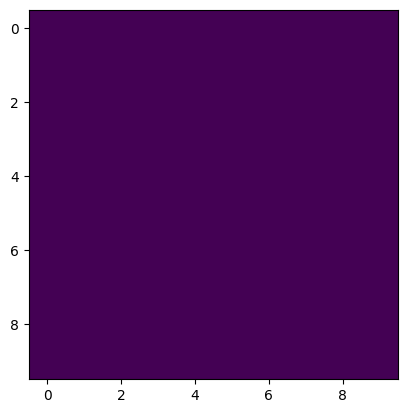

Evaluation 192 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 190.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.36it/s]


Completed. Saving
Time (s) to complete simulation 192: 0.9609172344207764


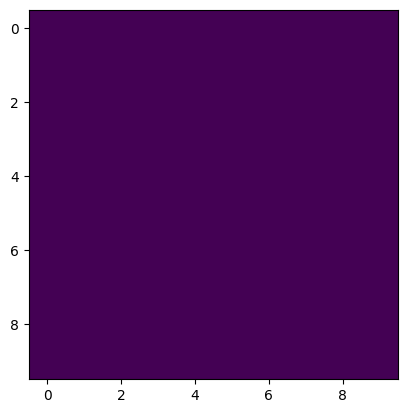

Evaluation 193 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 183.20it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.53it/s]


Completed. Saving
Time (s) to complete simulation 193: 0.9716594219207764


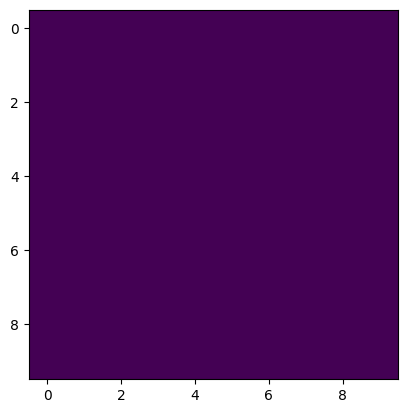

Evaluation 194 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 171.33it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.45it/s]


Completed. Saving
Time (s) to complete simulation 194: 0.9889137744903564


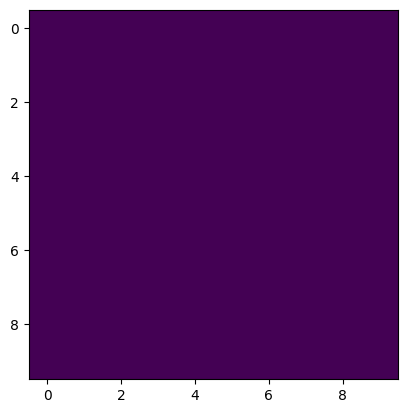

Evaluation 195 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 167.31it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 73.05it/s]


Completed. Saving
Time (s) to complete simulation 195: 0.9977200031280518


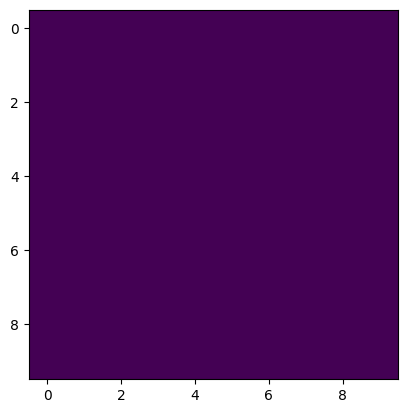

Evaluation 196 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 178.61it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 72.43it/s]


Completed. Saving
Time (s) to complete simulation 196: 0.9895110130310059


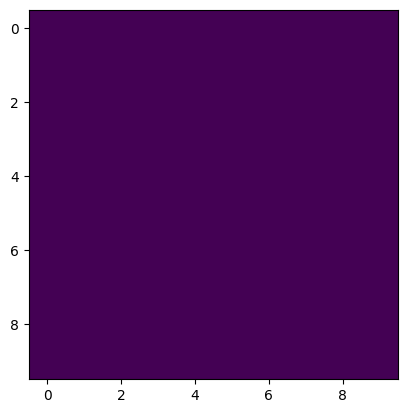

Evaluation 197 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 186.42it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 61.59it/s]


Completed. Saving
Time (s) to complete simulation 197: 1.1009407043457031


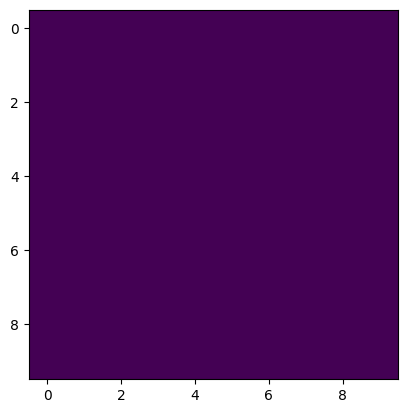

Evaluation 198 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 118.85it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 45.02it/s]


Completed. Saving
Time (s) to complete simulation 198: 1.550919532775879


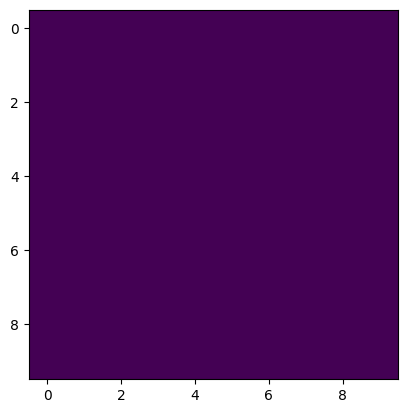

Evaluation 199 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 124.17it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 44.08it/s]


Completed. Saving
Time (s) to complete simulation 199: 1.556196689605713


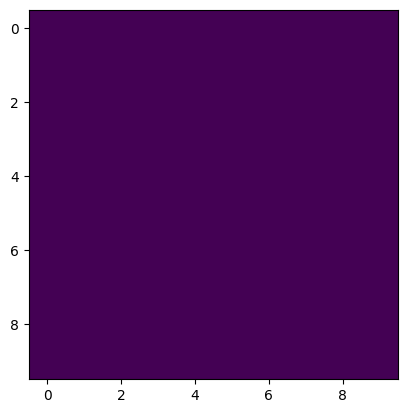

Evaluation 200 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 115.56it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:01<00:00, 43.08it/s]


Completed. Saving
Time (s) to complete simulation 200: 1.6149945259094238


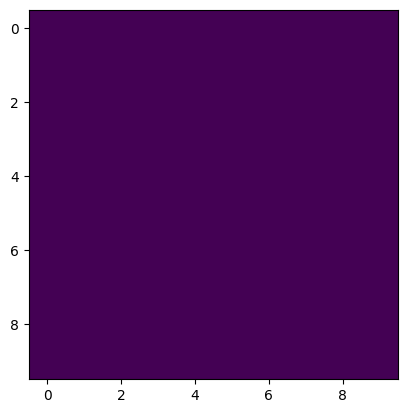

Evaluation 201 of 201

---Performing Equlibration---



100%|██████████| 50/50 [00:00<00:00, 120.54it/s]



---Finished...
----Performing MC Moves----



100%|██████████| 50/50 [00:00<00:00, 60.02it/s]


Completed. Saving
Time (s) to complete simulation 201: 1.2635066509246826


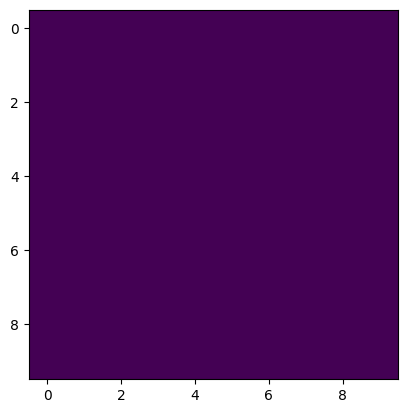

In [8]:
Jx = xs

results_dict = {}
approx_ys = np.zeros(xs.shape[0])
approx_ys1 = np.zeros(xs.shape[0])
approx_ys2 = np.zeros(xs.shape[0])

time_eval = np.zeros(xs.shape[0])

for i in range(0, Jx.shape[0]):
    J_mat = np.array([[0,0,0,0,0],
                      [0,0,Jx[i],0,0],
                      [0,Jx[i],0,Jx[i],0],
                      [0,0,Jx[i],0,0],
                      [0,0,0,0,0]])
    print("Evaluation " +str (i+1) +" of " +str(N_total))
    start_time = time.time()
    np.random.seed(0)
    sq_sim = IsingSim(N = 10, J_mat = J_mat, T = 2.7, save_trajectories=True, eqSteps = 50, mcSteps = 50)  # Intializing the object
    sq_sim.performIsingSim()   # Running the sim
    end_time = time.time()
    time_eval[i]= end_time-start_time
    print("Time (s) to complete simulation " +str(i+1)+ ": " +str(time_eval[i]))
    results_dict[i] = {'sim': sq_sim.results,}

    approx_ys[i] = results_dict[i]['sim']['SpecificHeat']
    approx_ys1[i] = results_dict[i]['sim']['Magnetization']
    approx_ys2[i] = results_dict[i]['sim']['Susceptibility']

    plt.imshow(results_dict[i]['sim']['config'][-1])
    plt.show()

(1.0291544442153095, 0.3534164788697096)

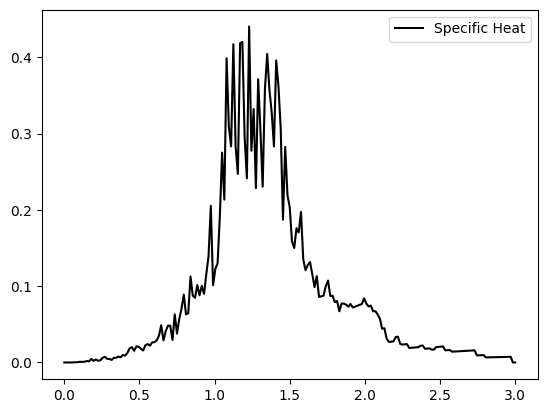

In [9]:
plt.plot(xs, approx_ys, "k", label="Specific Heat")
plt.legend(loc="best")
np.mean(time_eval), np.std(time_eval)

## Symbolic Regression


Problem 6. The code above has calculated the specific heat, magnetization, and susceptibility as a function of chosen parameter. Use PySR to find the symbolic form for one of them.

Note that the data clearly has several regimes, e.g. for the code above we cross the phase transition. It may be difficult to find the equation that describes the behavior of the chosen function across full parameter space. Hence, experiment with:
- Fitting full data set
- Generate the data only above pahse transition
- And only below

 So as the output you have three functions.

# End of Module 1

Congratulations - we are at the end of module 1! Next we are going to dive into the world of differential equations and physics-informed neural networks.